In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import re
import unicodedata
import nltk
import csv
import string
from textblob import TextBlob
from nltk.corpus import stopwords

In [ ]:

madaniyah_chapters = []
with open('/content/drive/MyDrive/google-quran-translate-evaluation/madaniyah.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)
    for row in csv_reader:
        madaniyah_chapters.append(int(row[1]))

In [ ]:

pd.options.display.max_colwidth = 250


In [ ]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
# import torchtext
# from torchtext import data

import transformers
from transformers import BertTokenizer, BertModel, BertConfig

import warnings
warnings.filterwarnings('ignore')
import operator

from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

from matplotlib.ticker import StrMethodFormatter

In [ ]:
topic_df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_2.csv')MAX_LEN = 128
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 3
LEARNING_RATE = 1e-05 #tried 1e-03, 1e-04, 1e-05
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-large-p1')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.teks = dataframe['teks']
        self.targets = self.dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.teks)

    def __getitem__(self, index):
        teks = str(self.teks[index])
        teks = " ".join(teks.split())

        inputs = self.tokenizer.encode_plus(
            teks,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids' : torch.tensor(ids, dtype = torch.long),
            'mask' : torch.tensor(mask, dtype = torch.long),
            'token_type_ids' : torch.tensor(token_type_ids, dtype = torch.long),
            'targets' : torch.tensor(self.targets[index], dtype = torch.float)
        }

In [ ]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('indobenchmark/indobert-large-p1')
        self.layer2 = torch.nn.Dropout(0.3)
        self.layer3 = torch.nn.Linear(1024, 11)

    def forward(self, ids, mask, token_type_ids, return_dict = False):
        unw, out_1 = self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[0], self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

model = BERT()
model.to(device)

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, eleme

In [ ]:
#import torch

bert = torch.load("/content/drive/MyDrive/Colab Notebooks/bert-large-p1-finetuned-sem_eval-indo.pth",map_location=torch.device(device))
bert

OrderedDict([('bert.embeddings.word_embeddings.weight',
              tensor([[-0.0262, -0.0276, -0.1143,  ..., -0.0261, -0.0273,  0.0138],
                      [-0.0589, -0.0238, -0.0488,  ...,  0.0132, -0.0212, -0.0142],
                      [ 0.0036, -0.0097, -0.0235,  ..., -0.0050, -0.0062,  0.0075],
                      ...,
                      [-0.0023, -0.0050, -0.1443,  ..., -0.0316,  0.0866, -0.0469],
                      [ 0.0134, -0.0458, -0.1035,  ...,  0.0148, -0.0028,  0.0120],
                      [-0.0269, -0.0153, -0.1343,  ..., -0.0498, -0.0103, -0.0139]],
                     device='cuda:0')),
             ('bert.embeddings.position_embeddings.weight',
              tensor([[-1.7698e-02,  1.2116e-02, -7.1822e-05,  ...,  1.5574e-02,
                        2.0488e-02, -1.2581e-02],
                      [-1.7690e-02, -5.4845e-03,  1.0082e-02,  ...,  2.0044e-02,
                        2.2580e-02,  1.6869e-02],
                      [-3.5187e-02, -8.1973e-03,  

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/weights_only.pth')

In [ ]:
model_new = BERT()
model_new.to(device)

model_new.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/weights_only.pth'))

model_new

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, eleme

In [ ]:
def test(model):
    model.eval()
    model_outputs = []

    with torch.no_grad():
        for data in test_loader:
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)

            outputs = model(ids, mask, token_type_ids)
            model_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return model_outputs


### google translate

In [ ]:
for chapter in madaniyah_chapters:

  new_df = pd.DataFrame()

  verses_df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/data/google_translate/chapter_' + str(chapter) + '.csv')

  new_df['teks'] = verses_df['google_translate']
  values = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * len(verses_df)
  new_df['list'] = values

  test_dataset = CustomDataset(new_df, tokenizer, MAX_LEN)

  bert_test_params = {'batch_size': 1,
                    'shuffle': False,
                    'num_workers': 0
                    }

  test_loader = DataLoader(test_dataset, **bert_test_params)

  test_outputs = test(model_new)

  test_outputs = np.array(test_outputs)

  for i in range(test_outputs.shape[0]):
      for j in range(test_outputs.shape[1]):
          if test_outputs[i][j] >= 0.5: test_outputs[i][j] = 1
          else: test_outputs[i][j] = 0

  new_df['amarah'] = "None"
  new_df['antisipasi'] = "None"
  new_df['menjijikkan'] = "None"
  new_df['takut'] = "None"
  new_df['sukacita'] = "None"
  new_df['Cinta'] = "None"
  new_df['optimisme'] = "None"
  new_df['pesimisme'] = "None"
  new_df['kesedihan'] = "None"
  new_df['kejutan'] = "None"
  new_df['memercayai'] = "None"
  new_df = new_df.drop(['list'], axis = 1)

  for i in range(len(test_outputs)):
    new_df['amarah'].iloc[i] = test_outputs[i][0]
    new_df['antisipasi'].iloc[i] = test_outputs[i][1]
    new_df['menjijikkan'].iloc[i] = test_outputs[i][2]
    new_df['takut'].iloc[i] = test_outputs[i][3]
    new_df['sukacita'].iloc[i] = test_outputs[i][4]
    new_df['Cinta'].iloc[i] = test_outputs[i][5]
    new_df['optimisme'].iloc[i] = test_outputs[i][6]
    new_df['pesimisme'].iloc[i] = test_outputs[i][7]
    new_df['kesedihan'].iloc[i] = test_outputs[i][8]
    new_df['kejutan'].iloc[i] = test_outputs[i][9]
    new_df['memercayai'].iloc[i] = test_outputs[i][10]

    new_df.tail(5)

    new_df.to_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_' + str(chapter) + '.csv', index=False)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'amarah'),
  Text(1, 0, 'antisipasi'),
  Text(2, 0, 'menjijikkan'),
  Text(3, 0, 'takut'),
  Text(4, 0, 'sukacita'),
  Text(5, 0, 'Cinta'),
  Text(6, 0, 'optimisme'),
  Text(7, 0, 'pesimisme'),
  Text(8, 0, 'kesedihan'),
  Text(9, 0, 'kejutan'),
  Text(10, 0, 'memercayai')])

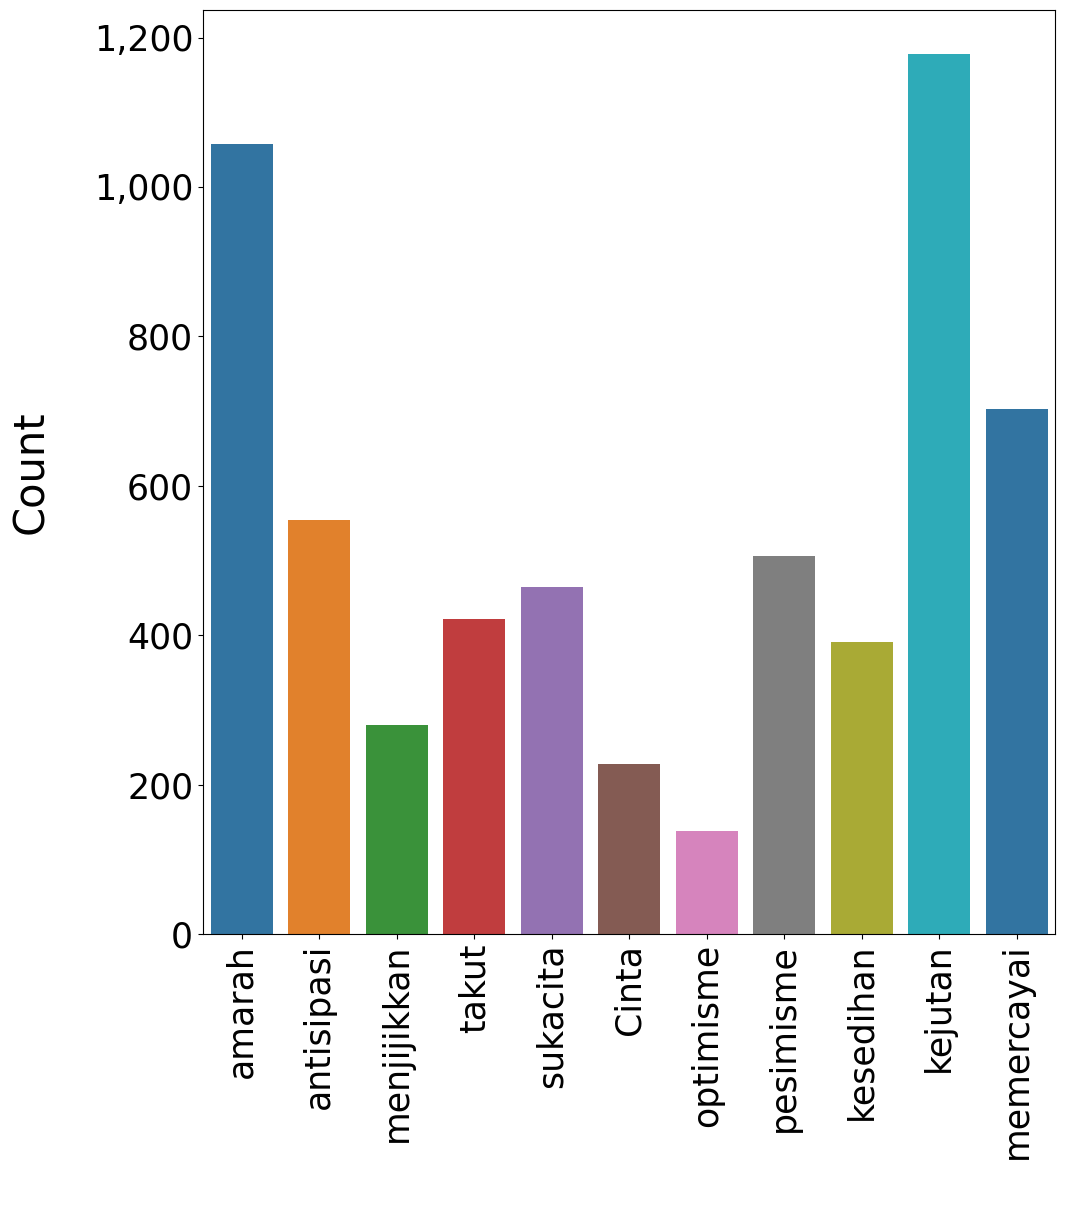

In [ ]:
total_df = pd.DataFrame()

for chapter in madaniyah_chapters:
  df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_' + str(chapter) + '.csv')

  df = df.drop(['teks'], axis=1)
  df = df.apply(pd.Series.value_counts)

  df['amarah'] = df['amarah'].fillna(0)
  df['antisipasi'] = df['antisipasi'].fillna(0)
  df['menjijikkan'] = df['menjijikkan'].fillna(0)
  df['takut'] = df['takut'].fillna(0)
  df['sukacita'] = df['sukacita'].fillna(0)
  df['Cinta'] = df['Cinta'].fillna(0)
  df['optimisme'] = df['optimisme'].fillna(0)
  df['pesimisme'] = df['pesimisme'].fillna(0)
  df['kesedihan'] = df['kesedihan'].fillna(0)
  df['kejutan'] = df['kejutan'].fillna(0)
  df['memercayai'] = df['memercayai'].fillna(0)

  df = df.iloc[1]

  df = pd.DataFrame(df)

  df.columns = [ 'Count']

  total_df = pd.concat([total_df, df])

total_df = total_df.reset_index()
total_df = total_df.rename(columns={"index":"Sentiment"})

new_df = pd.DataFrame({"Sentiment":["amarah", "antisipasi", "menjijikkan", "takut", "sukacita", "Cinta", "optimisme", "pesimisme", "kesedihan", "kejutan", "memercayai"],
                       "Count":[0,0,0,0,0,0,0,0,0,0,0]})

for ii in range(0, 11):
  for jj in range(0, 19):
    new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df.loc[jj*11+ii, 'Count']).astype(int)

fig_dims = (11, 12)
fig, ax = plt.subplots(figsize=fig_dims)


sns.barplot(x = new_df.Sentiment, y = new_df.Count, ax = ax, palette = sns.color_palette("tab10"))

plt.xticks(rotation=90)

plt.ylabel('Count', labelpad=30)
plt.xlabel(' ')
# plt.title('All Chapters', fontsize = 25,  pad=25)
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
plt.yticks(fontsize= 25)
plt.xticks(fontsize = 25)
plt.savefig('')

### kemenag

In [ ]:
for chapter in madaniyah_chapters:

  new_df = pd.DataFrame()

  verses_df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/data/kemenag/chapter_' + str(chapter) + '.csv')

  new_df['teks'] = verses_df['kemenag']
  values = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * len(verses_df)
  new_df['list'] = values

  test_dataset = CustomDataset(new_df, tokenizer, MAX_LEN)

  bert_test_params = {'batch_size': 1,
                    'shuffle': False,
                    'num_workers': 0
                    }

  test_loader = DataLoader(test_dataset, **bert_test_params)

  test_outputs = test(model_new)

  test_outputs = np.array(test_outputs)

  for i in range(test_outputs.shape[0]):
      for j in range(test_outputs.shape[1]):
          if test_outputs[i][j] >= 0.5: test_outputs[i][j] = 1
          else: test_outputs[i][j] = 0

  new_df['amarah'] = "None"
  new_df['antisipasi'] = "None"
  new_df['menjijikkan'] = "None"
  new_df['takut'] = "None"
  new_df['sukacita'] = "None"
  new_df['Cinta'] = "None"
  new_df['optimisme'] = "None"
  new_df['pesimisme'] = "None"
  new_df['kesedihan'] = "None"
  new_df['kejutan'] = "None"
  new_df['memercayai'] = "None"
  new_df = new_df.drop(['list'], axis = 1)

  for i in range(len(test_outputs)):
    new_df['amarah'].iloc[i] = test_outputs[i][0]
    new_df['antisipasi'].iloc[i] = test_outputs[i][1]
    new_df['menjijikkan'].iloc[i] = test_outputs[i][2]
    new_df['takut'].iloc[i] = test_outputs[i][3]
    new_df['sukacita'].iloc[i] = test_outputs[i][4]
    new_df['Cinta'].iloc[i] = test_outputs[i][5]
    new_df['optimisme'].iloc[i] = test_outputs[i][6]
    new_df['pesimisme'].iloc[i] = test_outputs[i][7]
    new_df['kesedihan'].iloc[i] = test_outputs[i][8]
    new_df['kejutan'].iloc[i] = test_outputs[i][9]
    new_df['memercayai'].iloc[i] = test_outputs[i][10]

    new_df.tail(5)

    new_df.to_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted kemenag/chapter_' + str(chapter) + '.csv', index=False)

### Fahd

In [ ]:
for chapter in madaniyah_chapters:

  new_df = pd.DataFrame()

  verses_df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/data/king_fahd/chapter_' + str(chapter) + '.csv')

  new_df['teks'] = verses_df['king_fahd']
  values = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * len(verses_df)
  new_df['list'] = values

  test_dataset = CustomDataset(new_df, tokenizer, MAX_LEN)

  bert_test_params = {'batch_size': 1,
                    'shuffle': False,
                    'num_workers': 0
                    }

  test_loader = DataLoader(test_dataset, **bert_test_params)

  test_outputs = test(model_new)

  test_outputs = np.array(test_outputs)

  for i in range(test_outputs.shape[0]):
      for j in range(test_outputs.shape[1]):
          if test_outputs[i][j] >= 0.5: test_outputs[i][j] = 1
          else: test_outputs[i][j] = 0

  new_df['amarah'] = "None"
  new_df['antisipasi'] = "None"
  new_df['menjijikkan'] = "None"
  new_df['takut'] = "None"
  new_df['sukacita'] = "None"
  new_df['Cinta'] = "None"
  new_df['optimisme'] = "None"
  new_df['pesimisme'] = "None"
  new_df['kesedihan'] = "None"
  new_df['kejutan'] = "None"
  new_df['memercayai'] = "None"
  new_df = new_df.drop(['list'], axis = 1)

  for i in range(len(test_outputs)):
    new_df['amarah'].iloc[i] = test_outputs[i][0]
    new_df['antisipasi'].iloc[i] = test_outputs[i][1]
    new_df['menjijikkan'].iloc[i] = test_outputs[i][2]
    new_df['takut'].iloc[i] = test_outputs[i][3]
    new_df['sukacita'].iloc[i] = test_outputs[i][4]
    new_df['Cinta'].iloc[i] = test_outputs[i][5]
    new_df['optimisme'].iloc[i] = test_outputs[i][6]
    new_df['pesimisme'].iloc[i] = test_outputs[i][7]
    new_df['kesedihan'].iloc[i] = test_outputs[i][8]
    new_df['kejutan'].iloc[i] = test_outputs[i][9]
    new_df['memercayai'].iloc[i] = test_outputs[i][10]

    new_df.tail(5)

    new_df.to_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted fahd/chapter_' + str(chapter) + '.csv', index=False)

In [ ]:
def all_chapter_dataframe(path):
  total_df = pd.DataFrame()

  for chapter in madaniyah_chapters:
    df = pd.read_csv(path + str(chapter) + '.csv')

    df = df.drop(['teks'], axis=1)
    df = df.apply(pd.Series.value_counts)

    df['amarah'] = df['amarah'].fillna(0)
    df['antisipasi'] = df['antisipasi'].fillna(0)
    df['menjijikkan'] = df['menjijikkan'].fillna(0)
    df['takut'] = df['takut'].fillna(0)
    df['sukacita'] = df['sukacita'].fillna(0)
    df['Cinta'] = df['Cinta'].fillna(0)
    df['optimisme'] = df['optimisme'].fillna(0)
    df['pesimisme'] = df['pesimisme'].fillna(0)
    df['kesedihan'] = df['kesedihan'].fillna(0)
    df['kejutan'] = df['kejutan'].fillna(0)
    df['memercayai'] = df['memercayai'].fillna(0)

    df = df.iloc[1]

    df = pd.DataFrame(df)

    df.columns = [ 'Count']

    total_df = pd.concat([total_df, df])

  total_df = total_df.reset_index()
  total_df = total_df.rename(columns={"index":"Sentiment"})

  new_df = pd.DataFrame({"Sentiment":["amarah", "antisipasi", "menjijikkan", "takut", "sukacita", "Cinta", "optimisme", "pesimisme", "kesedihan", "kejutan", "memercayai"],
                       "Count":[0,0,0,0,0,0,0,0,0,0,0]})

  for ii in range(0, 11):
    for jj in range(0, 19):
      new_df.loc[ii, 'Count'] = (new_df.loc[ii, 'Count'] + total_df.loc[jj*11+ii, 'Count']).astype(int)

  return new_df

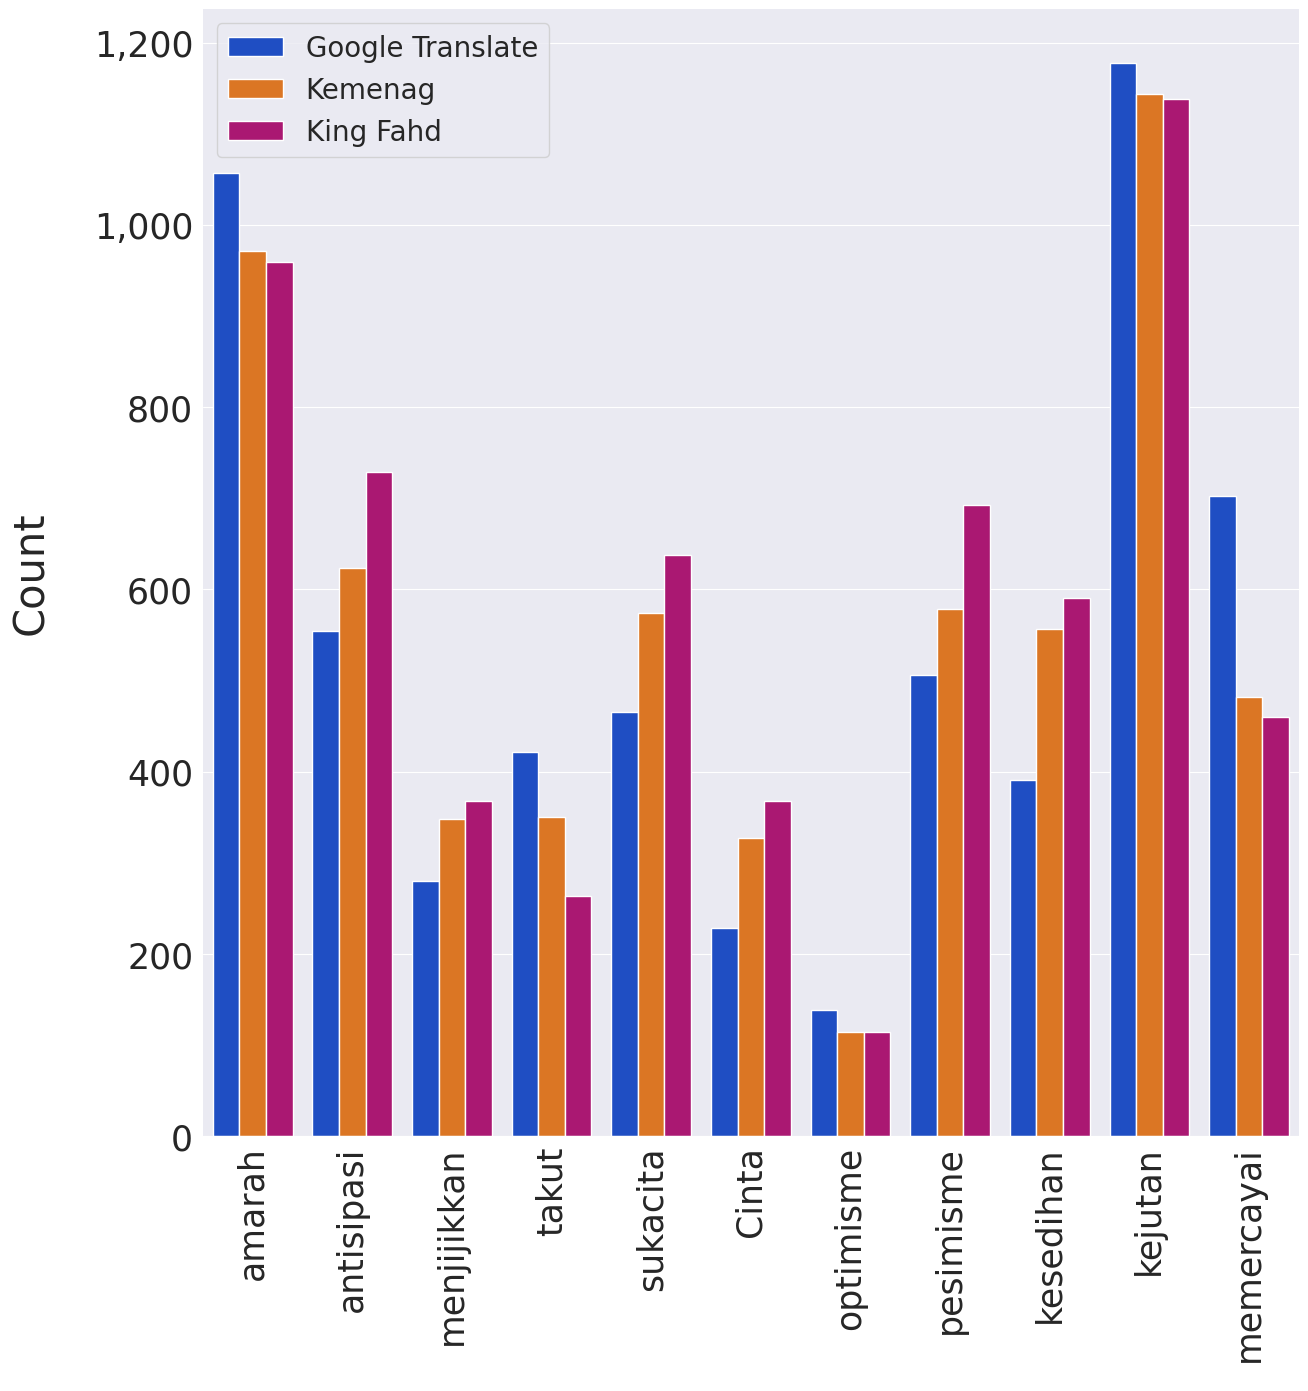

In [ ]:
google_translate = all_chapter_dataframe('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_')
kemenag = all_chapter_dataframe('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted kemenag/chapter_')
king_fahd = all_chapter_dataframe('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted fahd/chapter_')

df_new = pd.concat([
    google_translate['Sentiment'],
    google_translate['Count'],
    kemenag['Count'],
    king_fahd['Count']
], axis=1)

df_new.columns = ['Sentiment', 'Google Translate', 'Kemenag', 'King Fahd']


df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")

# sns.color_palette("tab10")

# sns.factorplot(x='Sentiment', y='Count', hue='Author, data=df_new, kind='bar', height=10, palette = "tab10")

colors = ["blue", "orange", "magenta", "green"]
myPalette = sns.xkcd_palette(colors)

sns.set_style("darkgrid")
g = sns.catplot(x='Sentiment', y='Count', hue='Author', data=df_new, kind='bar', height=12, palette = myPalette)
g._legend.remove()

g.despine(left=True)

plt.legend(loc='best',prop={"size":20})

plt.ylabel('Count', labelpad=30, fontsize=30)
plt.xlabel(' ')

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    # format decimals on the y-axis
plt.yticks(fontsize= 25)
plt.xticks(fontsize = 25)
plt.xticks(rotation=90)
plt.savefig('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/Chapterwise predicted sentiments bar plots/all.png',  bbox_inches='tight', dpi=300)

In [ ]:
def chapter_wise_dataframe(path, chapter):

    df = pd.read_csv(path + str(chapter) + '.csv')

    df = df.drop(['teks'], axis=1)
    df = df.apply(pd.Series.value_counts)

    df['amarah'] = df['amarah'].fillna(0)
    df['antisipasi'] = df['antisipasi'].fillna(0)
    df['menjijikkan'] = df['menjijikkan'].fillna(0)
    df['takut'] = df['takut'].fillna(0)
    df['sukacita'] = df['sukacita'].fillna(0)
    df['Cinta'] = df['Cinta'].fillna(0)
    df['optimisme'] = df['optimisme'].fillna(0)
    df['pesimisme'] = df['pesimisme'].fillna(0)
    df['kesedihan'] = df['kesedihan'].fillna(0)
    df['kejutan'] = df['kejutan'].fillna(0)
    df['memercayai'] = df['memercayai'].fillna(0)


    df = df.iloc[1]

    df = pd.DataFrame(df)

    df.columns = [ 'Count']

    return df

In [ ]:
import os


output_dir = '/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/Chapterwise predicted sentiments bar plots'
os.makedirs(output_dir, exist_ok=True)

for chapter in madaniyah_chapters:

  google_translate = chapter_wise_dataframe('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_', chapter)
  kemenag = chapter_wise_dataframe('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted kemenag/chapter_', chapter)
  king_fahd = chapter_wise_dataframe('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted fahd/chapter_', chapter)

  df_new = pd.concat([
    google_translate['Count'],
    kemenag['Count'],
    king_fahd['Count']
  ], axis=1)

  df_new.columns = ['Google Translate', 'Kemenag', 'King Fahd']
  df_new = df_new.reset_index()
  df_new = df_new.rename(columns={"index":"Sentiment"})

  df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")

  colors = ["blue", "orange", "green","magenta"]
  myPalette = sns.xkcd_palette(colors)

  sns.set_style("darkgrid")
  g = sns.catplot(
      x='Sentiment', y='Count', hue='Author', data=df_new,
      kind='bar', height=12, aspect=1.2, palette=myPalette
  )

  g.despine(left=True)
  g._legend.remove()
  plt.legend(loc='best', prop={"size":25})

  plt.ylabel('Count', labelpad=30, fontsize=30)
  plt.xlabel(' ')
  plt.xticks(rotation=90)
  plt.yticks(fontsize=35)
  plt.xticks(fontsize=35)
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

  # Simpan gambar berdasarkan nomor chapter
  save_path = os.path.join(output_dir, f'chapter_{chapter}_bar_plot.png')
  plt.savefig(save_path, bbox_inches='tight', dpi=300)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_new.head()

,Sentiment,Author,Count
0,amarah,Google Translate,9.0
1,antisipasi,Google Translate,2.0
2,menjijikkan,Google Translate,4.0
3,takut,Google Translate,5.0
4,sukacita,Google Translate,4.0


In [ ]:
df_new.reset_index()

,index,Sentiment,Author,Count
0,0,amarah,Google Translate,9.0
1,1,antisipasi,Google Translate,2.0
2,2,menjijikkan,Google Translate,4.0
3,3,takut,Google Translate,5.0
4,4,sukacita,Google Translate,4.0
5,5,Cinta,Google Translate,4.0
6,6,optimisme,Google Translate,0.0
7,7,pesimisme,Google Translate,3.0
8,8,kesedihan,Google Translate,5.0
9,9,kejutan,Google Translate,9.0


##heatmap google

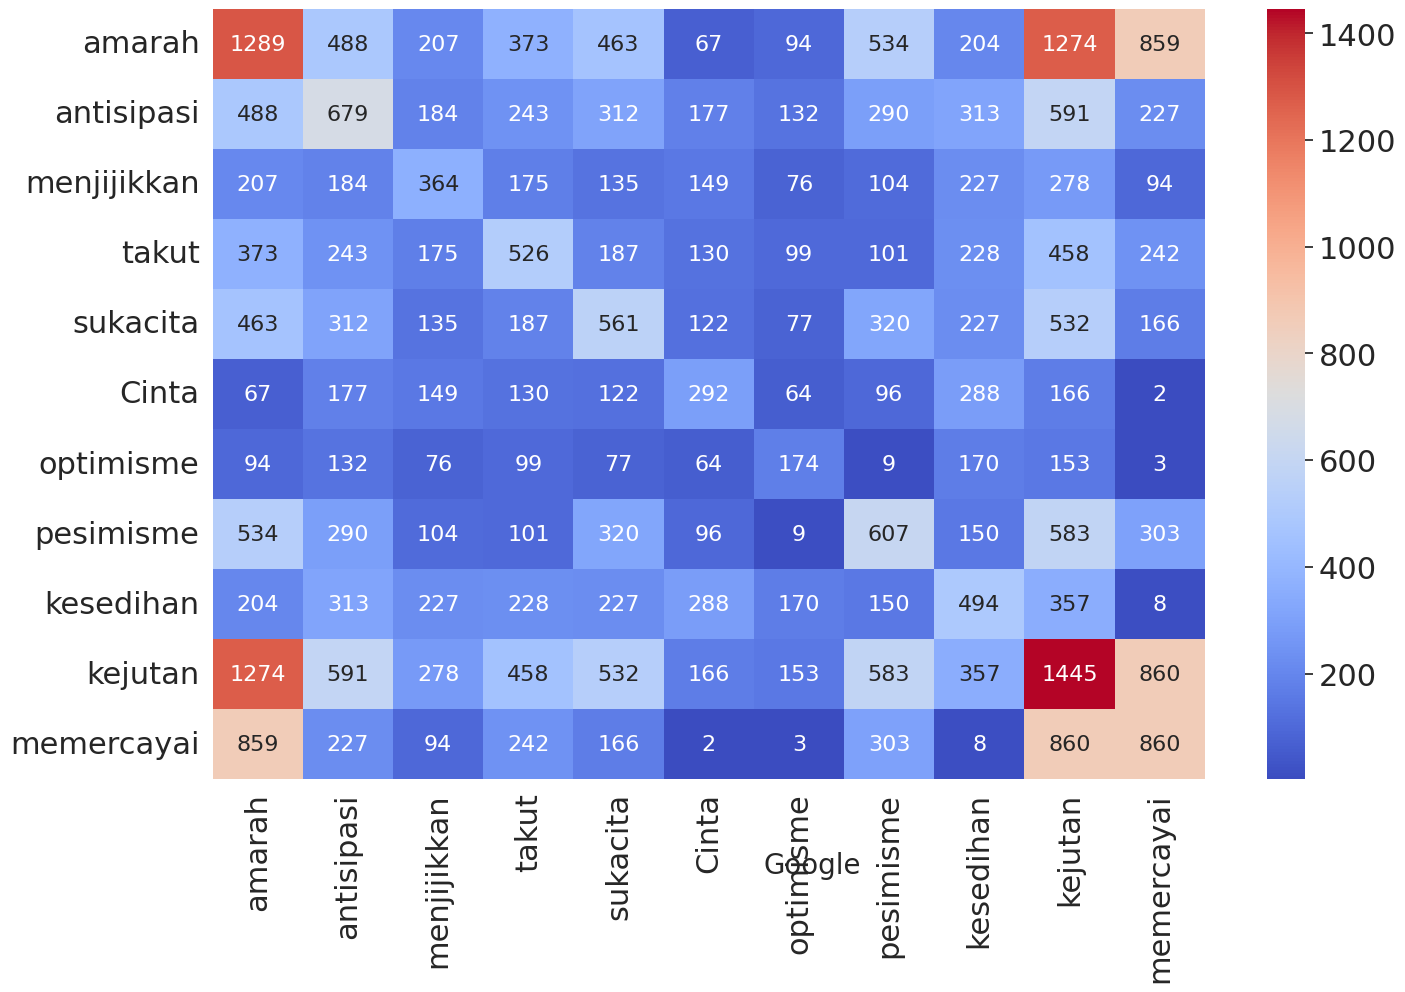

In [ ]:
heatmap_df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_2.csv')
heatmap_df = heatmap_df.drop(['teks'], axis=1)

for chapter in [c for c in madaniyah_chapters if c != '2']:
  df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_' + str(chapter) + '.csv')

  df = df.drop(['teks'], axis=1)

  heatmap_df = pd.concat([heatmap_df, df], axis=0)

emote_array = np.zeros((11, 11))
e2i = {
    'amarah' : 0, 'antisipasi' : 1, 'menjijikkan' : 2, 'takut' : 3, 'sukacita' : 4, 'Cinta' : 5, 'optimisme' : 6, 'pesimisme' : 7, 'kesedihan' : 8, 'kejutan' : 9, 'memercayai' : 10
}

for i in range(len(heatmap_df)):
    l = heatmap_df.iloc[i].tolist()
    for j in range(11):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 11):
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

emotions = ['amarah', 'antisipasi', 'menjijikkan', 'takut', 'sukacita', 'Cinta', 'optimisme', 'pesimisme', 'kesedihan', 'kejutan', 'memercayai']

emote_df = pd.DataFrame(emote_array, columns = emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)

fig = plt.figure(figsize = (16, 10))
sns.set(font_scale=2)
sns.heatmap(emote_df, annot = True, cmap = 'coolwarm', xticklabels = emote_df.columns, yticklabels = emote_df.columns,
            fmt = 'g', annot_kws = {"size" : 16})
# plt.title('Chapter ' + str(chapter), pad = 25)
fig.text(0.5, 0.01, 'Google', ha='center', va='bottom', fontsize=20)
plt.savefig('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/Heatmaps/heatmap_google.png', bbox_inches='tight', dpi=300)

##heatmap kemenag

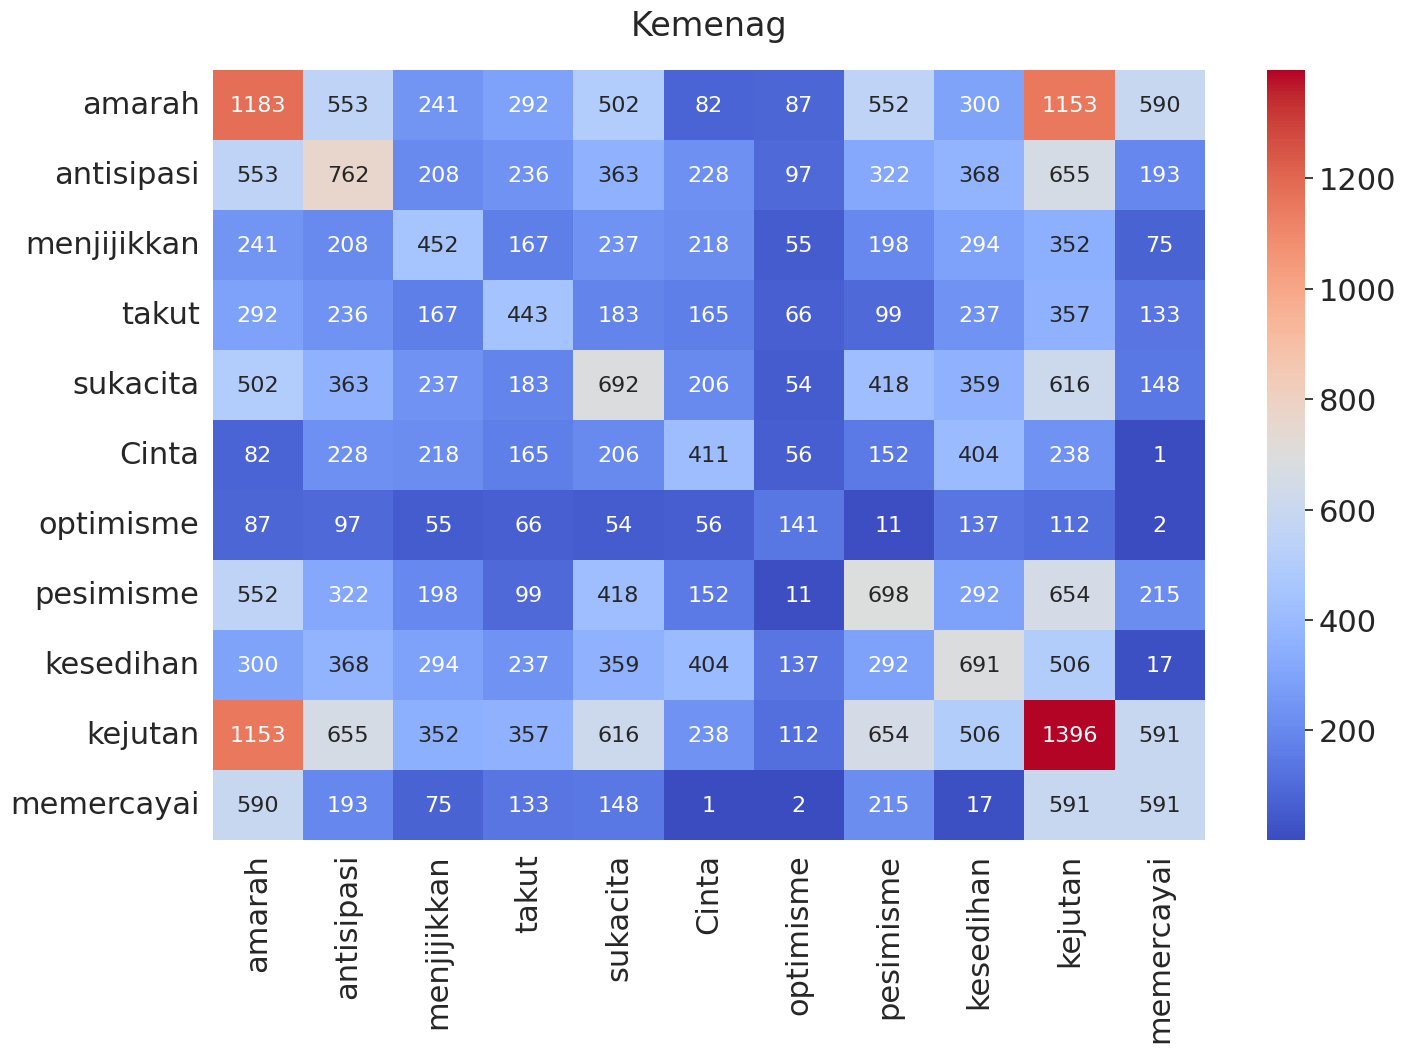

In [ ]:
heatmap_df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted kemenag/chapter_2.csv')
heatmap_df = heatmap_df.drop(['teks'], axis=1)

for chapter in [c for c in madaniyah_chapters if c != '2']:
  df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted kemenag/chapter_' + str(chapter) + '.csv')

  df = df.drop(['teks'], axis=1)

  heatmap_df = pd.concat([heatmap_df, df], axis=0)

emote_array = np.zeros((11, 11))
e2i = {
    'amarah' : 0, 'antisipasi' : 1, 'menjijikkan' : 2, 'takut' : 3, 'sukacita' : 4, 'Cinta' : 5, 'optimisme' : 6, 'pesimisme' : 7, 'kesedihan' : 8, 'kejutan' : 9, 'memercayai' : 10
}

for i in range(len(heatmap_df)):
    l = heatmap_df.iloc[i].tolist()
    for j in range(11):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 11):
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

emotions = ['amarah', 'antisipasi', 'menjijikkan', 'takut', 'sukacita', 'Cinta', 'optimisme', 'pesimisme', 'kesedihan', 'kejutan', 'memercayai']

emote_df = pd.DataFrame(emote_array, columns = emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)

fig = plt.figure(figsize = (16, 10))
sns.set(font_scale=2)
sns.heatmap(emote_df, annot = True, cmap = 'coolwarm', xticklabels = emote_df.columns, yticklabels = emote_df.columns,
            fmt = 'g', annot_kws = {"size" : 16})
# plt.title('Chapter ' + str(chapter), pad = 25)
plt.title('Kemenag', pad=25)
plt.savefig('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/Heatmaps/heatmap_kemenag.png', bbox_inches='tight', dpi=300)

##heatmap fahd

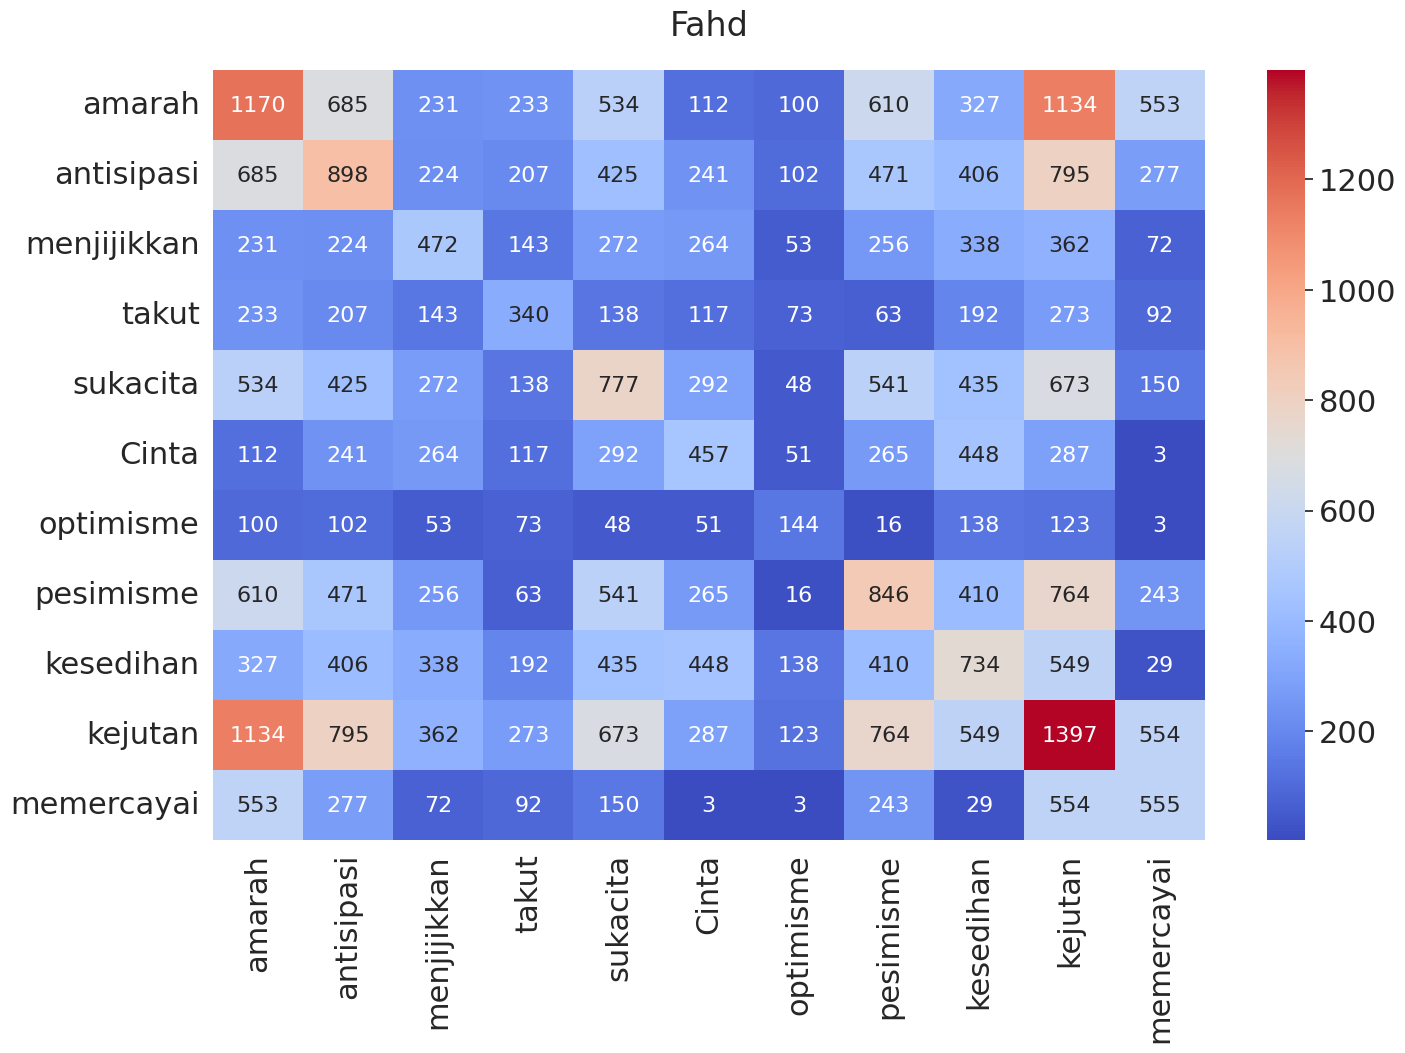

In [ ]:
heatmap_df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted fahd/chapter_2.csv')
heatmap_df = heatmap_df.drop(['teks'], axis=1)

for chapter in [c for c in madaniyah_chapters if c != '2']:
  df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted fahd/chapter_' + str(chapter) + '.csv')

  df = df.drop(['teks'], axis=1)

  heatmap_df = pd.concat([heatmap_df, df], axis=0)

emote_array = np.zeros((11, 11))
e2i = {
    'amarah' : 0, 'antisipasi' : 1, 'menjijikkan' : 2, 'takut' : 3, 'sukacita' : 4, 'Cinta' : 5, 'optimisme' : 6, 'pesimisme' : 7, 'kesedihan' : 8, 'kejutan' : 9, 'memercayai' : 10
}

for i in range(len(heatmap_df)):
    l = heatmap_df.iloc[i].tolist()
    for j in range(11):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 11):
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

emotions = ['amarah', 'antisipasi', 'menjijikkan', 'takut', 'sukacita', 'Cinta', 'optimisme', 'pesimisme', 'kesedihan', 'kejutan', 'memercayai']

emote_df = pd.DataFrame(emote_array, columns = emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)

fig = plt.figure(figsize = (16, 10))
sns.set(font_scale=2)
sns.heatmap(emote_df, annot = True, cmap = 'coolwarm', xticklabels = emote_df.columns, yticklabels = emote_df.columns,
            fmt = 'g', annot_kws = {"size" : 16})
# plt.title('Chapter ' + str(chapter), pad = 25)
plt.title('Fahd', pad=25)
plt.savefig('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/Heatmaps/heatmap_fahd.png', bbox_inches='tight', dpi=300)

<Axes: xlabel='Sentiment', ylabel='Count'>

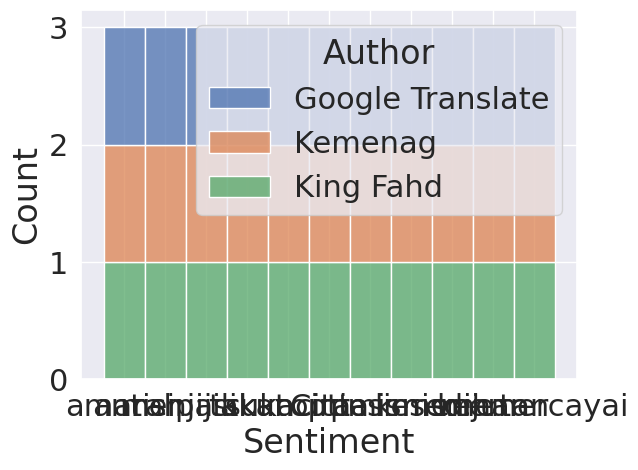

In [ ]:
google_translate = all_chapter_dataframe('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_')
kemenag = all_chapter_dataframe('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted kemenag/chapter_')
king_fahd = all_chapter_dataframe('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted fahd/chapter_')

df_new = pd.concat([
    google_translate['Sentiment'],
    google_translate['Count'],
    kemenag['Count'],
    king_fahd['Count']
], axis=1)

df_new.columns = ['Sentiment', 'Google Translate', 'Kemenag', 'King Fahd']
df_new = pd.melt(df_new, id_vars="Sentiment", var_name="Author", value_name="Count")

sns.histplot(data= df_new, x='Sentiment', hue='Author', multiple= 'stack')


In [ ]:
df_new

,Sentiment,Author,Count
0,amarah,Google Translate,1057
1,antisipasi,Google Translate,554
2,menjijikkan,Google Translate,280
3,takut,Google Translate,421
4,sukacita,Google Translate,465
5,Cinta,Google Translate,228
6,optimisme,Google Translate,138
7,pesimisme,Google Translate,506
8,kesedihan,Google Translate,391
9,kejutan,Google Translate,1178


In [ ]:
from sklearn.metrics import jaccard_score

In [ ]:
!pip install df2img -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.9 MB/s eta 0:00:00


In [ ]:
google_translate_chapter_two = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_2.csv')
kemenag_chapter_two = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted kemenag/chapter_2.csv')
king_fahd_chapter_two = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted fahd/chapter_2.csv')


google_translate_chapter_2 = google_translate_chapter_two.drop(['teks'], axis=1)
kemenag_chapter_2 = kemenag_chapter_two.drop(['teks'], axis=1)
king_fahd_chapter_2 = king_fahd_chapter_two.drop(['teks'], axis=1)

In [ ]:
kemenag_chapter_two

,teks,amarah,antisipasi,menjijikkan,takut,sukacita,Cinta,optimisme,pesimisme,kesedihan,kejutan,memercayai
0,"Kitab (Alquran) ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,"(Yaitu) mereka yang beriman kepada yang gaib, melaksanakan salat, dan menginfakkan sebagian rezeki yang Kami berikan kepada mereka,",1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,"dan mereka beriman kepada (Alquran) yang diturunkan kepadamu (Muhammad) dan (kitab-kitab) yang telah diturunkan sebelum engkau, dan mereka yakin akan adanya akhirat.",1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,"Merekalah yang mendapat petunjuk dari Tuhannya, dan mereka itulah orang-orang yang beruntung.",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,"Sesungguhnya orang-orang kafir, sama saja bagi mereka, engkau (Muhammad) beri peringatan atau tidak engkau beri peringatan, mereka tidak akan beriman.",1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
280,"Wahai orang-orang yang beriman! Apabila kamu melakukan utang piutang untuk waktu yang ditentukan, hendaklah kamu menuliskannya. Dan hendaklah seorang penulis di antara kamu menuliskannya dengan benar. Janganlah penulis menolak untuk menuliskannya...",1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
281,"Dan jika kamu dalam perjalanan sedang kamu tidak mendapat seorang penulis, maka hendaklah ada barang jaminan yang dipegang. Tetapi, jika sebagian kamu mempercayai sebagian yang lain, hendaklah yang dipercayai itu menunaikan amanatnya (utangnya) d...",0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
282,"Milik Allahlah apa yang ada di langit dan apa yang ada di bumi. Jika kamu nyatakan apa yang ada di dalam hatimu atau kamu sembunyikan, niscaya Allah memperhitungankannya (tentang perbuatan itu) bagimu. Dia mengampuni siapa yang Dia kehendaki dan ...",1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
283,"Rasul (Muhammad) beriman kepada apa yang diturunkan kepadanya (Alquran) dari Tuhannya, demikian pula orang-orang yang beriman. Semua beriman kepada Allah, malaikat-malaikat-Nya, kitab-kitab-Nya, dan rasul-rasul-Nya. (Mereka berkata), ""Kami tidak ...",0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
google_translate_chapter_two

,teks,amarah,antisipasi,menjijikkan,takut,sukacita,Cinta,optimisme,pesimisme,kesedihan,kejutan,memercayai
0,Kitab ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa.,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,"Orang-orang yang beriman kepada yang gaib, mendirikan shalat, dan menafkahkan sebagian rezeki yang Kami berikan kepada mereka.",1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,"Dan orang-orang yang beriman kepada kitab yang diturunkan kepadamu dan kitab yang diturunkan sebelum kamu, dan kepada kehidupan akhirat, mereka adalah yakin.",1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,Mereka itulah yang mendapat petunjuk dari Tuhannya dan mereka itulah orang-orang yang beruntung.,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,"Sesungguhnya orang-orang kafir, sama saja bagi mereka, kamu beri peringatan atau tidak kamu beri peringatan, mereka tidak akan beriman.",1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
280,"Hai orang-orang yang beriman, jika kamu berutang untuk waktu yang ditentukan, maka tulislah. Dan hendaklah seorang penulis mencatat di antara kamu dengan adil. Dan janganlah seorang penulis pun enggan menuliskan sebagaimana yang telah diajarkan A...",1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
281,"۞ Dan jika kamu dalam perjalanan dan tidak menemukan seorang penulis, maka berikanlah jaminan. Dan jika salah seorang di antara kamu mempercayai yang lain, hendaklah orang yang dipercaya itu menunaikan amanahnya, dan hendaklah ia bertakwa kepada ...",1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
282,"Kepunyaan Allah-lah apa yang ada di langit dan apa yang ada di bumi. Dan jika kamu menampakkan apa yang ada dalam dirimu atau menyembunyikannya, niscaya Allah akan meminta pertanggungjawaban kepadamu. Kemudian Dia akan mengampuni siapa yang Dia ...",1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
283,"Rasulullah telah beriman kepada apa yang diturunkan kepadanya dari Tuhannya, dan begitu pula orang-orang mukmin. Mereka semua telah beriman kepada Allah, para malaikat-Nya, kitab-kitab-Nya, dan para rasul-Nya. Kami tidak membeda-bedakan seorang p...",0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
row = king_fahd_chapter_2.iloc[284, :]
row

,284
amarah,0.0
antisipasi,0.0
menjijikkan,1.0
takut,1.0
sukacita,1.0
Cinta,1.0
optimisme,0.0
pesimisme,0.0
kesedihan,1.0
kejutan,0.0


In [ ]:
king_fahd_chapter_2

,amarah,antisipasi,menjijikkan,takut,sukacita,Cinta,optimisme,pesimisme,kesedihan,kejutan,memercayai
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
280,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
281,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
282,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
283,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
import numpy as np
from sklearn.metrics import jaccard_score
y_true = np.array([[0, 1, 1],
                   [1, 1, 0]])
y_pred = np.array([[1, 1, 1],
                   [1, 0, 0]])

In [ ]:
for ii in range(0, google_translate_chapter_2.shape[0]):
  print(jaccard_score(king_fahd_chapter_2.iloc[ii, :], google_translate_chapter_2.iloc[ii, :]))

0.4
0.8
0.3333333333333333
1.0
1.0
1.0
0.4444444444444444
0.8
0.6666666666666666
0.2857142857142857
0.6
0.42857142857142855
0.6
0.5
0.5
0.5
0.6
0.6666666666666666
0.3333333333333333
0.6666666666666666
0.42857142857142855
0.6
0.75
0.5714285714285714
0.2222222222222222
0.8333333333333334
0.8333333333333334
1.0
0.8
0.0
0.3333333333333333
0.75
0.25
0.375
0.3333333333333333
0.75
0.375
0.6666666666666666
0.8333333333333334
0.2857142857142857
0.8
0.6666666666666666
0.2857142857142857
0.3333333333333333
0.5
0.3333333333333333
0.3333333333333333
0.6
0.3333333333333333
0.6666666666666666
1.0
0.5
0.42857142857142855
0.42857142857142855
0.75
0.125
0.2857142857142857
1.0
0.125
0.7142857142857143
0.42857142857142855
0.42857142857142855
1.0
0.375
1.0
0.8333333333333334
0.6
0.8
0.2857142857142857
0.5
0.8
0.375
1.0
0.6666666666666666
0.6
1.0
0.8
0.6666666666666666
0.6666666666666666
0.42857142857142855
0.75
0.3333333333333333
0.5
0.375
0.75
0.5
0.5
0.75
0.5
0.42857142857142855
0.8
0.6666666666666666
0.

In [ ]:
from sklearn.metrics import jaccard_score
import pandas as pd

df_gk = pd.DataFrame()
df_gf = pd.DataFrame()
df_kf = pd.DataFrame()

chapter_list = []
gk_list = []
gf_list = []
kf_list = []

mean_gk_list = []
mean_gf_list = []
mean_kf_list = []

sum_gk = 0
sum_gf = 0
sum_kf = 0

for chapter in madaniyah_chapters:
    # Load prediksi per chapter
    google = pd.read_csv(f'/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_{chapter}.csv')
    kemenag = pd.read_csv(f'/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted kemenag/chapter_{chapter}.csv')
    fahd = pd.read_csv(f'/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted fahd/chapter_{chapter}.csv')

    # Drop kolom yang tidak diperlukan
    drop_cols = ['teks']
    google = google.drop(columns=[col for col in drop_cols if col in google.columns])
    kemenag = kemenag.drop(columns=[col for col in drop_cols if col in kemenag.columns])
    fahd = fahd.drop(columns=[col for col in drop_cols if col in fahd.columns])

    # Hitung Jaccard Score per ayat
    for i in range(len(google)):
        gk_list.append(jaccard_score(google.iloc[i, :], kemenag.iloc[i, :]))
        gf_list.append(jaccard_score(google.iloc[i, :], fahd.iloc[i, :]))
        kf_list.append(jaccard_score(kemenag.iloc[i, :], fahd.iloc[i, :]))

    # Simpan rata-rata per chapter
    chapter_list.append(chapter)

    mean_gk = pd.Series(gk_list).mean()
    mean_gf = pd.Series(gf_list).mean()
    mean_kf = pd.Series(kf_list).mean()

    mean_gk_list.append(mean_gk)
    mean_gf_list.append(mean_gf)
    mean_kf_list.append(mean_kf)

    print(f'Chapter {chapter} Average:')
    print(f'Google vs. Kemenag: {mean_gk:.4f}')
    print(f'Google vs. Fahd   : {mean_gf:.4f}')
    print(f'Kemenag vs. Fahd  : {mean_kf:.4f}\n')

    # Tambahkan ke total
    sum_gk += mean_gk
    sum_gf += mean_gf
    sum_kf += mean_kf

# Buat dataframe akhir untuk disimpan atau diplot
df_summary = pd.DataFrame({
    'Chapter': chapter_list,
    'Google vs Kemenag': mean_gk_list,
    'Google vs Fahd': mean_gf_list,
    'Kemenag vs Fahd': mean_kf_list
})

# Simpan jika perlu
df_summary = df_summary.round(3)
df_summary.to_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/jaccard_table_summary.csv', index=False)

# Cetak rata-rata total
print('--- TOTAL AVERAGE ---')
print(f'Google vs. Kemenag: {sum_gk / len(chapter_list):.3f}')
print(f'Google vs. Fahd   : {sum_gf / len(chapter_list):.3f}')
print(f'Kemenag vs. Fahd  : {sum_kf / len(chapter_list):.3f}')


Chapter 2 Average:
Google vs. Kemenag: 0.6207
Google vs. Fahd   : 0.5931
Kemenag vs. Fahd  : 0.6387

Chapter 3 Average:
Google vs. Kemenag: 0.5938
Google vs. Fahd   : 0.5768
Kemenag vs. Fahd  : 0.6463

Chapter 4 Average:
Google vs. Kemenag: 0.6002
Google vs. Fahd   : 0.5943
Kemenag vs. Fahd  : 0.6592

Chapter 5 Average:
Google vs. Kemenag: 0.6010
Google vs. Fahd   : 0.5918
Kemenag vs. Fahd  : 0.6558

Chapter 9 Average:
Google vs. Kemenag: 0.6037
Google vs. Fahd   : 0.5967
Kemenag vs. Fahd  : 0.6623

Chapter 24 Average:
Google vs. Kemenag: 0.6031
Google vs. Fahd   : 0.5947
Kemenag vs. Fahd  : 0.6609

Chapter 33 Average:
Google vs. Kemenag: 0.6073
Google vs. Fahd   : 0.5984
Kemenag vs. Fahd  : 0.6667

Chapter 47 Average:
Google vs. Kemenag: 0.6058
Google vs. Fahd   : 0.5979
Kemenag vs. Fahd  : 0.6667

Chapter 48 Average:
Google vs. Kemenag: 0.6070
Google vs. Fahd   : 0.5965
Kemenag vs. Fahd  : 0.6677

Chapter 49 Average:
Google vs. Kemenag: 0.6089
Google vs. Fahd   : 0.5984
Kemenag vs. F

In [ ]:
chapter_list

[2, 3, 4, 5, 9, 24, 33, 47, 48, 49, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]

In [ ]:
sum_gk=sum_gk/20
sum_gf=sum_gf/20
sum_kf=sum_kf/20

print('--- TOTAL AVERAGE ---')
print(f'Google vs. Kemenag: {sum_gk:.4f}')
print(f'Google vs. Fahd   : {sum_gf:.4f}')
print(f'Kemenag vs. Fahd  : {sum_kf:.4f}')

--- TOTAL AVERAGE ---
Google vs. Kemenag: 0.6091
Google vs. Fahd   : 0.5977
Kemenag vs. Fahd  : 0.6665


In [ ]:
# Buat DataFrame gabungan hasil Jaccard Score rata-rata per chapter

df_gk = pd.DataFrame({
    'Chapter': chapter_list,
    'Google vs Kemenag': mean_gk_list
})

df_gf = pd.DataFrame({
    'Chapter': chapter_list,
    'Google vs Fahd': mean_gf_list
})

df_kf = pd.DataFrame({
    'Chapter': chapter_list,
    'Kemenag vs Fahd': mean_kf_list
})

# Tampilkan salah satunya
print(df_gk)


    Chapter  Google vs Kemenag
0         2           0.620710
1         3           0.593781
2         4           0.600241
3         5           0.600955
4         9           0.603747
5        24           0.603098
6        33           0.607343
7        47           0.605780
8        48           0.607025
9        49           0.608943
10       57           0.608209
11       58           0.610688
12       59           0.613235
13       60           0.613345
14       61           0.612746
15       62           0.614145
16       63           0.613586
17       64           0.614604
18       65           0.614113
19       66           0.615410


In [ ]:
df_combined = pd.DataFrame({
    'Chapter': chapter_list,
    'Google vs Kemenag': mean_gk_list,
    'Google vs Fahd': mean_gf_list,
    'Kemenag vs Fahd': mean_kf_list
})


print(df_combined)

    Chapter  Google vs Kemenag  Google vs Fahd  Kemenag vs Fahd
0         2           0.620710        0.593092         0.638676
1         3           0.593781        0.576824         0.646288
2         4           0.600241        0.594310         0.659187
3         5           0.600955        0.591809         0.655798
4         9           0.603747        0.596734         0.662290
5        24           0.603098        0.594712         0.660913
6        33           0.607343        0.598370         0.666749
7        47           0.605780        0.597884         0.666736
8        48           0.607025        0.596534         0.667734
9        49           0.608943        0.598359         0.669949
10       57           0.608209        0.598190         0.671612
11       58           0.610688        0.600101         0.672406
12       59           0.613235        0.601636         0.673536
13       60           0.613345        0.601379         0.674091
14       61           0.612746        0.

In [ ]:
Google_Kemenag_avg_score = df_combined['Google vs Kemenag'].mean()
Google_Fahd_avg_score = df_combined['Google vs Fahd'].mean()
Kemenag_Fahd_avg_score = df_combined['Kemenag vs Fahd'].mean()

print("Google vs Kemenag Average Jaccard Score:", Google_Kemenag_avg_score)
print("Google vs Fahd Average Jaccard Score:", Google_Fahd_avg_score)
print("Kemenag vs Fahd Average Jaccard Score:", Kemenag_Fahd_avg_score)


Google vs Kemenag Average Jaccard Score: 0.6090852441066963
Google vs Fahd Average Jaccard Score: 0.5976867287650922
Kemenag vs Fahd Average Jaccard Score: 0.6665156637456089


In [ ]:
data=pd.melt(df_combined, ['Chapter'])

In [ ]:
data['Chapter'] = data['Chapter'].astype(str)

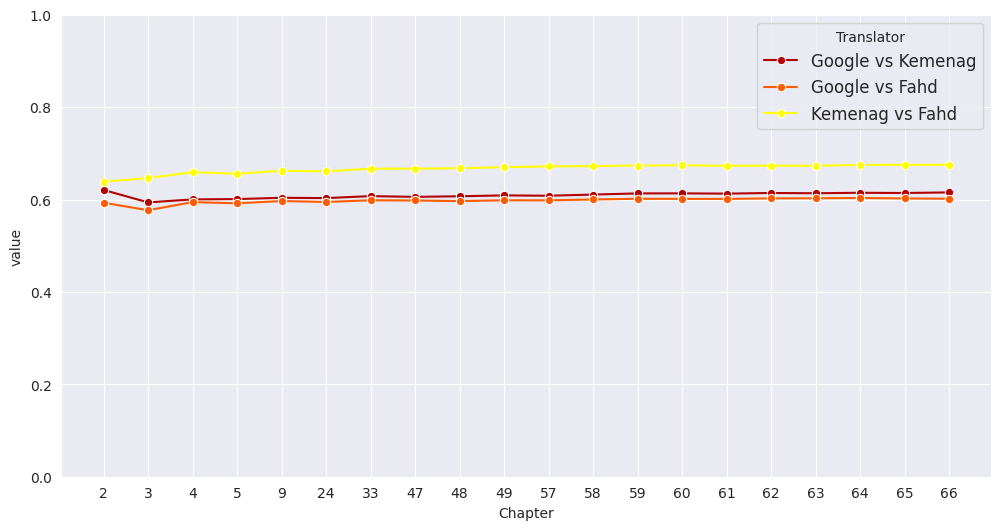

In [ ]:
sns.set_style("darkgrid")

fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.lineplot(x='Chapter', y='value', hue='variable', data=data, ax = ax)

sns.lineplot(x='Chapter',y='value',  hue = 'variable', data=data,
             palette = 'hot', dashes= False, marker= 'o', ax=ax)
ax.set_ylim(0, 1)
ax.legend(loc='best', fontsize=12, title='Translator')
plt.savefig('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/jaccard_line_plot.png', bbox_inches='tight', dpi=300)

In [ ]:
sentiment_polarity = {
    "amarah": -1,
    "antisipasi": 0,
    "menjijikkan": -1,
    "takut": -1,
    "sukacita": 1,
    "Cinta": 1,
    "optimisme": 1,
    "pesimisme": -1,
    "kesedihan": -1,
    "kejutan": 0,
    "memercayai": 1
}

In [ ]:
!pip install chart_studio -q
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Plotly to create interactive graph
import chart_studio.plotly as py
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.3 MB/s eta 0:00:00


In [ ]:
import chart_studio.plotly as py
from plotly import tools
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=False)
import plotly.figure_factory as ff
import plotly.graph_objs as go

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# To remove un-necessary warnings
import warnings
warnings.filterwarnings("ignore")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']

## Polarity Google

In [ ]:
# Inisialisasi variabel
df_sentiments = pd.DataFrame(columns=['Chapter', 'Polarity'])
chapter = 2

for chapter in madaniyah_chapters:
    try:
        df = pd.read_csv(f'/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_{chapter}.csv')
        df = df.drop(columns=['teks'], errors='ignore')

        polarity = 0

        for _, row in df.iterrows():
            for label, value in sentiment_polarity.items():
                if row.get(label, 0) == 1:
                    polarity += value

        df_sentiments = pd.concat([
            df_sentiments,
            pd.DataFrame([[chapter, polarity]], columns=['Chapter', 'Polarity'])
        ], ignore_index=True)

    except Exception as e:
        print(f"Gagal membaca chapter {chapter}: {e}")
        continue

df_sentiments = df_sentiments.sort_values('Chapter')

df_sentiments.reset_index()
df_sentiments.set_index('Chapter')

# Lihat hasil
print(df_sentiments)

   Chapter Polarity
0        2     -261
1        3     -178
2        4     -154
3        5     -122
4        9      -99
5       24      -59
6       33      -60
7       47      -38
8       48      -15
9       49      -16
10      57      -21
11      58      -14
12      59      -18
13      60       -8
14      61      -11
15      62      -12
16      63      -10
17      64      -11
18      65      -14
19      66      -11


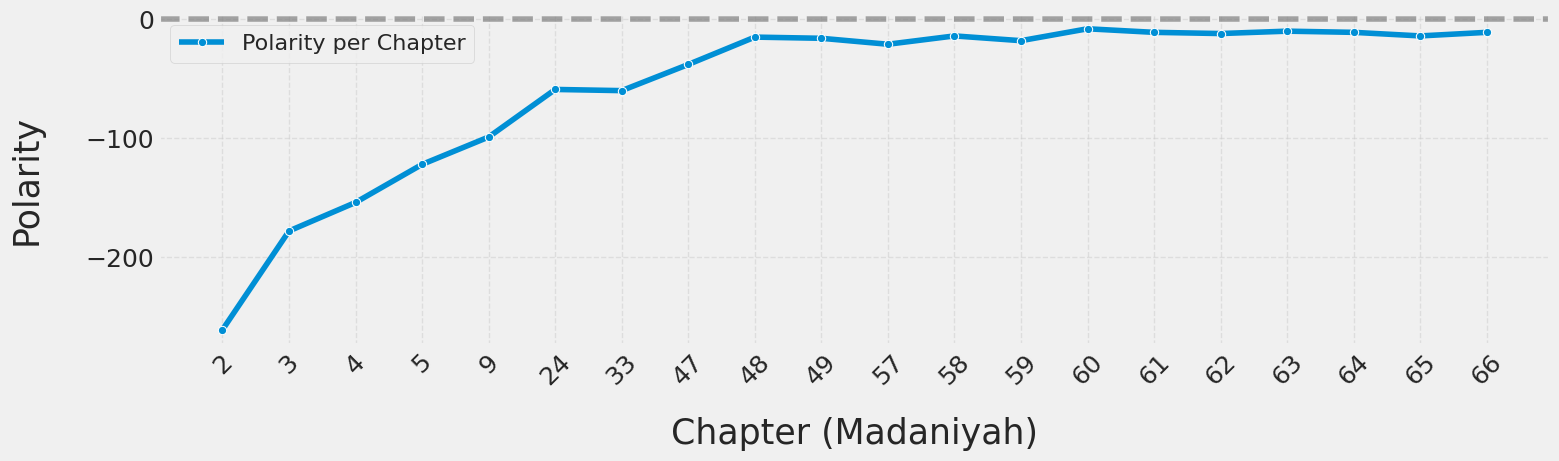

In [ ]:
# Ubah Chapter ke string agar seaborn treat as kategori
df_sentiments['Chapter'] = df_sentiments['Chapter'].astype(str)

# Urutkan berdasarkan urutan numerik meskipun sekarang string
df_sentiments = df_sentiments.sort_values(by='Chapter', key=lambda x: x.astype(int))

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16, 5))

sns.lineplot(x='Chapter', y='Polarity', data=df_sentiments, marker='o', label="Polarity per Chapter")

plt.ylabel('Polarity', labelpad=30, fontsize=25)
plt.xlabel('Chapter (Madaniyah)', labelpad=20, fontsize=25)

plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)

plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/Polarity/polarity_google.png', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
# Inisialisasi variabel
df_sentiments = pd.DataFrame(columns=['Chapter', 'Polarity'])
chapter = 2

for chapter in madaniyah_chapters:
    try:
        df = pd.read_csv(f'/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted kemenag/chapter_{chapter}.csv')
        df = df.drop(columns=['teks'], errors='ignore')

        polarity = 0

        for _, row in df.iterrows():
            for label, value in sentiment_polarity.items():
                if row.get(label, 0) == 1:
                    polarity += value

        df_sentiments = pd.concat([
            df_sentiments,
            pd.DataFrame([[chapter, polarity]], columns=['Chapter', 'Polarity'])
        ], ignore_index=True)

    except Exception as e:
        print(f"Gagal membaca chapter {chapter}: {e}")
        continue

df_sentiments['Chapter'] = df_sentiments['Chapter'].astype(int)
df_sentiments = df_sentiments.sort_values('Chapter')

df_sentiments.reset_index()
df_sentiments.set_index('Chapter')

# Lihat hasil
print(df_sentiments)

    Chapter Polarity
0         2     -312
1         3     -207
2         4     -193
3         5     -114
4         9     -117
5        24      -75
6        33      -72
7        47      -32
8        48      -24
9        49      -17
10       57      -20
11       58      -16
12       59      -16
13       60      -17
14       61      -13
15       62      -16
16       63      -14
17       64      -15
18       65      -17
19       66      -13


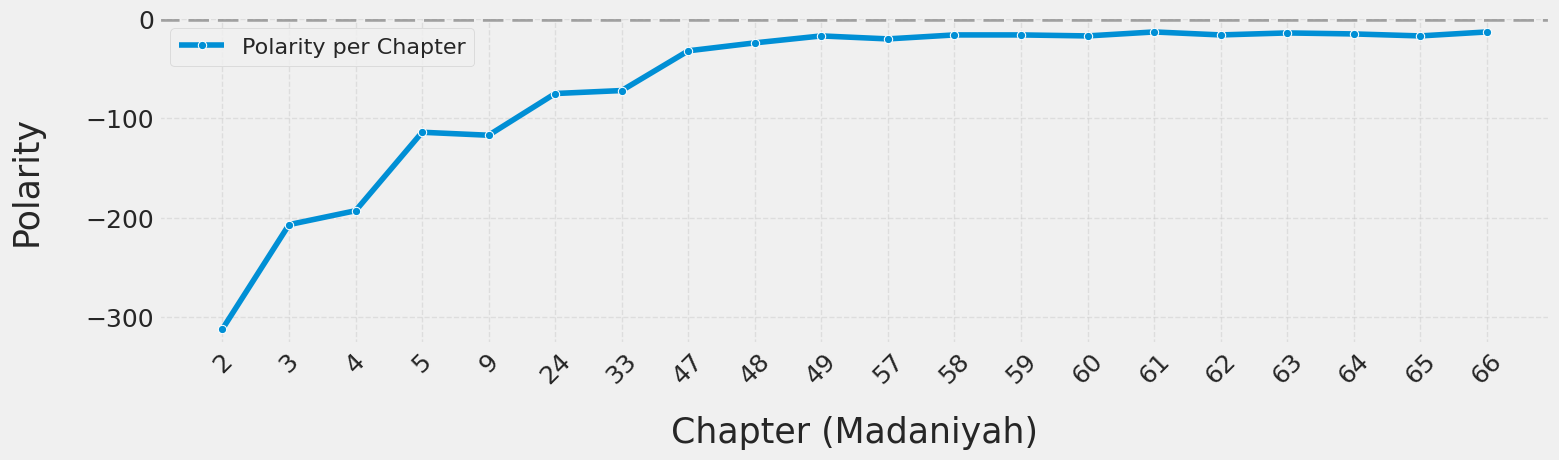

In [ ]:
# Ubah Chapter ke string agar seaborn treat as kategori
df_sentiments['Chapter'] = df_sentiments['Chapter'].astype(str)

# Urutkan berdasarkan urutan numerik meskipun sekarang string
df_sentiments = df_sentiments.sort_values(by='Chapter', key=lambda x: x.astype(int))

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16, 5))

sns.lineplot(x='Chapter', y='Polarity', data=df_sentiments, marker='o', label="Polarity per Chapter")

plt.ylabel('Polarity', labelpad=30, fontsize=25)
plt.xlabel('Chapter (Madaniyah)', labelpad=20, fontsize=25)

plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)

plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/Polarity/polarity_kemenag.png', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
# Inisialisasi variabel
df_sentiments = pd.DataFrame(columns=['Chapter', 'Polarity'])
chapter = 2

for chapter in madaniyah_chapters:
    try:
        df = pd.read_csv(f'/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted fahd/chapter_{chapter}.csv')
        df = df.drop(columns=['teks'], errors='ignore')

        polarity = 0

        for _, row in df.iterrows():
            for label, value in sentiment_polarity.items():
                if row.get(label, 0) == 1:
                    polarity += value

        df_sentiments = pd.concat([
            df_sentiments,
            pd.DataFrame([[chapter, polarity]], columns=['Chapter', 'Polarity'])
        ], ignore_index=True)

    except Exception as e:
        print(f"Gagal membaca chapter {chapter}: {e}")
        continue

df_sentiments['Chapter'] = df_sentiments['Chapter'].astype(int)
df_sentiments = df_sentiments.sort_values('Chapter')

df_sentiments.reset_index()
df_sentiments.set_index('Chapter')

# Lihat hasil
print(df_sentiments)

    Chapter Polarity
0         2     -321
1         3     -209
2         4     -178
3         5     -124
4         9     -136
5        24      -59
6        33      -70
7        47      -37
8        48      -16
9        49      -11
10       57      -24
11       58      -17
12       59      -14
13       60      -11
14       61      -12
15       62      -13
16       63       -9
17       64      -17
18       65      -16
19       66      -14


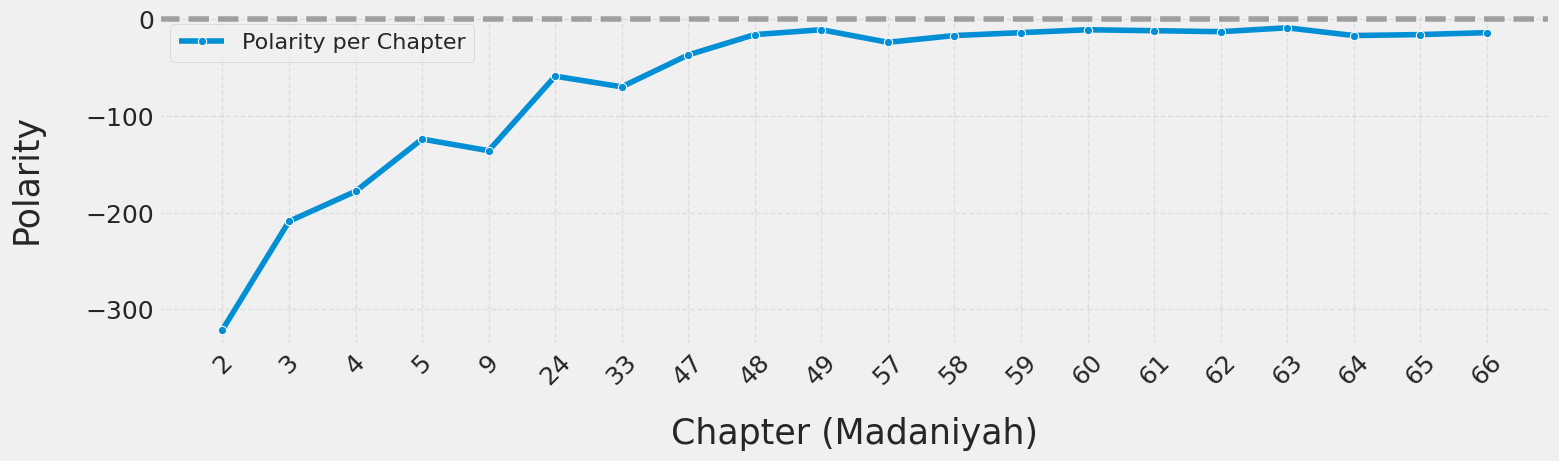

In [ ]:
# Ubah Chapter ke string agar seaborn treat as kategori
df_sentiments['Chapter'] = df_sentiments['Chapter'].astype(str)

# Urutkan berdasarkan urutan numerik meskipun sekarang string
df_sentiments = df_sentiments.sort_values(by='Chapter', key=lambda x: x.astype(int))

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16, 5))

sns.lineplot(x='Chapter', y='Polarity', data=df_sentiments, marker='o', label="Polarity per Chapter")

plt.ylabel('Polarity', labelpad=30, fontsize=25)
plt.xlabel('Chapter (Madaniyah)', labelpad=20, fontsize=25)

plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)

plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/Polarity/polarity_fahd.png', bbox_inches='tight', dpi=300)
plt.show()


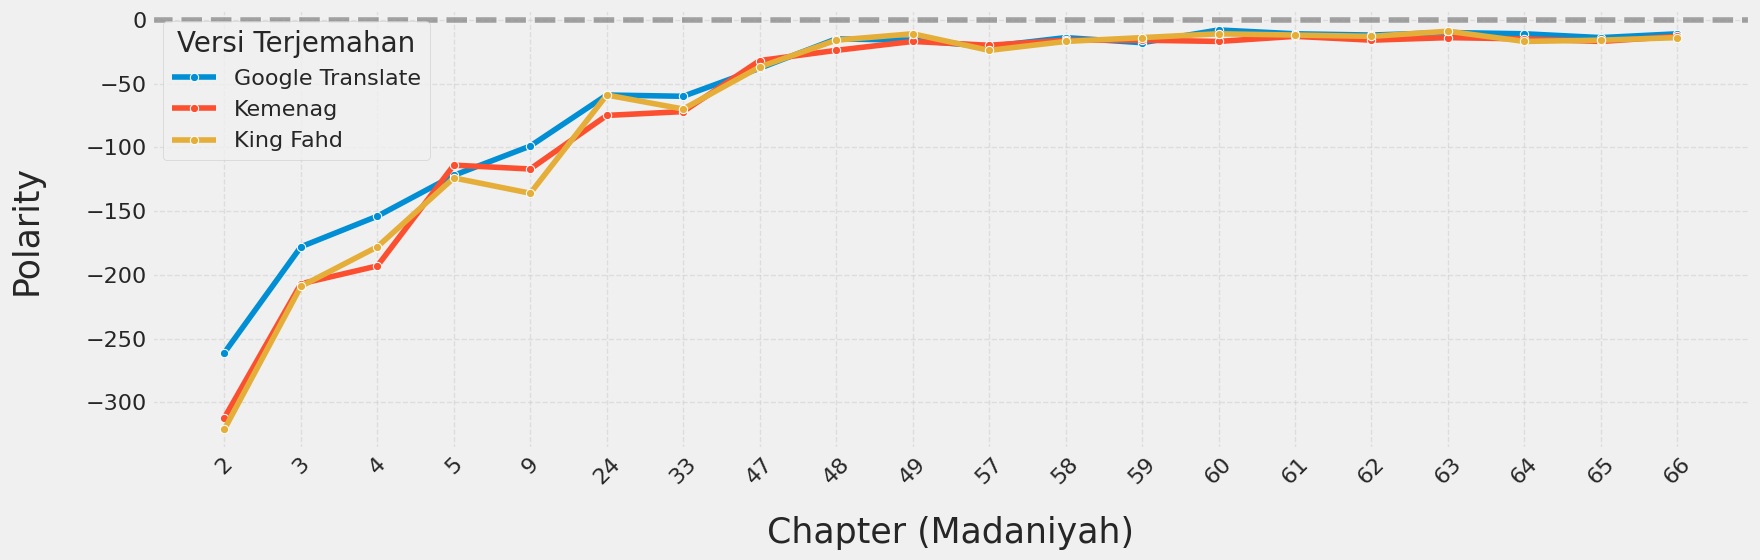

In [ ]:
# Dataframe akhir gabungan
df_all = pd.DataFrame(columns=['Chapter', 'Polarity', 'Source'])

# Fungsi untuk membaca data dan menghitung polaritas
def process_sentiment(source_name, path_prefix):
    df_sentiments = []
    for chapter in madaniyah_chapters:
        try:
            df = pd.read_csv(f'{path_prefix}/chapter_{chapter}.csv')
            df = df.drop(columns=['teks'], errors='ignore')

            polarity = 0
            for _, row in df.iterrows():
                for label, value in sentiment_polarity.items():
                    if row.get(label, 0) == 1:
                        polarity += value

            df_sentiments.append([str(chapter), polarity, source_name])

        except Exception as e:
            print(f"Gagal membaca chapter {chapter}: {e}")
            continue
    return pd.DataFrame(df_sentiments, columns=['Chapter', 'Polarity', 'Source'])

# Proses ketiga versi
df_google = process_sentiment("Google Translate", "/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google")
df_kemenag = process_sentiment("Kemenag", "/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted kemenag")
df_fahd = process_sentiment("King Fahd", "/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted fahd")

# Gabungkan semua
df_all = pd.concat([df_google, df_kemenag, df_fahd], ignore_index=True)

# Pastikan chapter terurut
df_all['Chapter'] = df_all['Chapter'].astype(int)
df_all = df_all.sort_values('Chapter')
df_all['Chapter'] = df_all['Chapter'].astype(str)

# Plot gabungan
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(18, 6))

sns.lineplot(x='Chapter', y='Polarity', hue='Source', data=df_all, marker='o')

plt.ylabel('Polarity', labelpad=30, fontsize=25)
plt.xlabel('Chapter (Madaniyah)', labelpad=20, fontsize=25)
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
plt.legend(fontsize=16, title="Versi Terjemahan")
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/Polarity/polarity_comparison.png', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
!pip install gensim -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you

In [ ]:
import gensim
from gensim import utils
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
topic_df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_2.csv')


for chapter in madaniyah_chapters:
  df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_' + str(chapter) + '.csv')
  topic_df = pd.concat([topic_df, df], axis=0)


In [ ]:
from nltk.corpus import stopwords

# Gunakan stopwords Bahasa Indonesia
stop_words = stopwords.words('indonesian')
custom_stopwords = ['orang', 'maha','sesungguhnya']
stop_words.extend(custom_stopwords)

def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(text)) if word not in stop_words] for text in texts]

def tokenize(texts):
    for text in texts:
        yield gensim.utils.simple_preprocess(str(text), deacc=True)

def preprocessing(df):
    df['teks'] = df['teks'].str.lower()
    df['teks'] = df['teks'].str.replace("[^a-zA-Z#]", " ", regex=True)
    df['teks'] = df['teks'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
    df['tokens'] = list(tokenize(df['teks']))
    df['tokens_no_stop'] = remove_stopwords(df['teks'])
    df['tokens_joined'] = df['teks'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))
    return df

def retrieve_text(df):
    return '. '.join(df['tokens_joined'])

def is_redundant_ngram(ngram):
    """True jika semua kata dalam ngram sama"""
    return len(set(ngram)) == 1

def is_blacklisted_ngram(ngram):
    """True jika ngram ada dalam daftar frasa yang dikecualikan"""
    blacklist = {
        ("allah", "allah"),
        ("maha", "maha"),
        ("ayat", "ayat"),
        ("bukti", "bukti", "nyata"),
        ("allah", "maha", "maha"),
        ("ayat", "ayat", "allah"),
        ("hukum", "hukum", "allah"),
    }
    return ngram in blacklist


def ngrams_series_func(text, n):
    words = re.sub("[^\w]", " ", text).split()
    ngram_list = nltk.ngrams(words, n)
    filtered = [ng for ng in ngram_list if not is_redundant_ngram(ng) and not is_blacklisted_ngram(ng)]
    return pd.Series(filtered).value_counts().head(10)


In [ ]:
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

In [ ]:
topic_df = preprocessing(topic_df)
topic_df

,teks,amarah,antisipasi,menjijikkan,takut,sukacita,Cinta,optimisme,pesimisme,kesedihan,kejutan,memercayai,tokens,tokens_no_stop,tokens_joined
0,kitab tidak keraguan padanya petunjuk bagi mereka yang bertakwa,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[kitab, tidak, keraguan, padanya, petunjuk, bagi, mereka, yang, bertakwa]","[kitab, keraguan, petunjuk, bertakwa]",kitab keraguan petunjuk bertakwa
1,orang orang yang beriman kepada yang gaib mendirikan shalat menafkahkan sebagian rezeki yang kami berikan kepada mereka,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[orang, orang, yang, beriman, kepada, yang, gaib, mendirikan, shalat, menafkahkan, sebagian, rezeki, yang, kami, berikan, kepada, mereka]","[beriman, gaib, mendirikan, shalat, menafkahkan, rezeki]",beriman gaib mendirikan shalat menafkahkan rezeki
2,orang orang yang beriman kepada kitab yang diturunkan kepadamu kitab yang diturunkan sebelum kamu kepada kehidupan akhirat mereka adalah yakin,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,"[orang, orang, yang, beriman, kepada, kitab, yang, diturunkan, kepadamu, kitab, yang, diturunkan, sebelum, kamu, kepada, kehidupan, akhirat, mereka, adalah, yakin]","[beriman, kitab, diturunkan, kepadamu, kitab, diturunkan, kehidupan, akhirat]",beriman kitab diturunkan kepadamu kitab diturunkan kehidupan akhirat
3,mereka itulah yang mendapat petunjuk dari tuhannya mereka itulah orang orang yang beruntung,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[mereka, itulah, yang, mendapat, petunjuk, dari, tuhannya, mereka, itulah, orang, orang, yang, beruntung]","[petunjuk, tuhannya, beruntung]",petunjuk tuhannya beruntung
4,sesungguhnya orang orang kafir sama saja bagi mereka kamu beri peringatan atau tidak kamu beri peringatan mereka tidak akan beriman,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,"[sesungguhnya, orang, orang, kafir, sama, saja, bagi, mereka, kamu, beri, peringatan, atau, tidak, kamu, beri, peringatan, mereka, tidak, akan, beriman]","[kafir, peringatan, peringatan, beriman]",kafir peringatan peringatan beriman
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,wahai orang orang yang beriman bertobatlah kepada allah dengan taubat yang tulus mudah mudahan tuhanmu akan menghapus kesalahan kesalahanmu memasukkanmu dalam surga yang mengalir bawahnya sungai sungai pada hari ketika allah tidak akan mempermalu...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,"[wahai, orang, orang, yang, beriman, bertobatlah, kepada, allah, dengan, taubat, yang, tulus, mudah, mudahan, tuhanmu, akan, menghapus, kesalahan, kesalahanmu, memasukkanmu, dalam, surga, yang, mengalir, bawahnya, sungai, sungai, pada, hari, keti...","[beriman, bertobatlah, allah, taubat, tulus, mudah, mudahan, tuhanmu, menghapus, kesalahan, kesalahanmu, memasukkanmu, surga, mengalir, bawahnya, sungai, sungai, allah, mempermalukan, nabi, beriman, bersamanya, cahaya, bersinar, hadapan, sebelah,...",beriman bertobatlah allah taubat tulus mudah mudahan tuhanmu menghapus kesalahan kesalahanmu memasukkanmu surga mengalir bawahnya sungai sungai allah mempermalukan nabi beriman bersamanya cahaya bersinar hadapan sebelah kanan tuhan sempurnakanlah...
8,wahai nabi perangilah orang orang kafir munafik bersikaplah keras terhadap mereka tempat kembali mereka adalah neraka seburuk buruk tempat kembali,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[wahai, nabi, perangilah, orang, orang, kafir, munafik, bersikaplah, keras, terhadap, mereka, tempat, kembali, mereka, adalah, neraka, seburuk, buruk, tempat, kembali]","[nabi, perangilah, kafir, munafik, bersikaplah, keras, neraka, seburuk, buruk]",nabi perangilah kafir munafik bersikaplah keras neraka seburuk buruk
9,allah menjadikan istri istri luth sebagai perumpamaan bagi orang orang yang kafir keduanya berada bawah pengawasan hamba kami yang saleh lalu keduanya mengkhianati keduanya maka keduanya tidak dapat menolong mereka sedikit dari allah dikatakan ma...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,"[allah, menjadikan, istri, istri, lu

In [ ]:
text = retrieve_text(topic_df)
print(text)

kitab keraguan petunjuk bertakwa. beriman gaib mendirikan shalat menafkahkan rezeki. beriman kitab diturunkan kepadamu kitab diturunkan kehidupan akhirat. petunjuk tuhannya beruntung. kafir peringatan peringatan beriman. allah mengunci hati pendengaran penglihatan tertutup tirai azab. manusia beriman allah beriman. menipu allah beriman menipu menyadari. hati penyakit ditambah allah penyakit azab pedih disebabkan berdusta. kerusakan muka bumi perbaikan. berbuat kerusakan menyadarinya. berimanlah manusia beriman haruskah beriman bodoh beriman sungguh bodoh. bertemu beriman beriman jahat beserta suka mempermainkan. allah mengolok olok menunda nunda pelanggaran tersesat kegelapan. membeli kesesatan imbalan petunjuk jual beli keuntungan petunjuk. perumpamaan menyalakan menerangi sekelilingnya allah hilangkan cahaya membiarkan kegelapan. tuli bisu buta. hujan turun langit dalamnya gelap gulita guntur kilat menutup telinga jari jari takut kematian allah meliputi kafir. kilat menyambar penglih

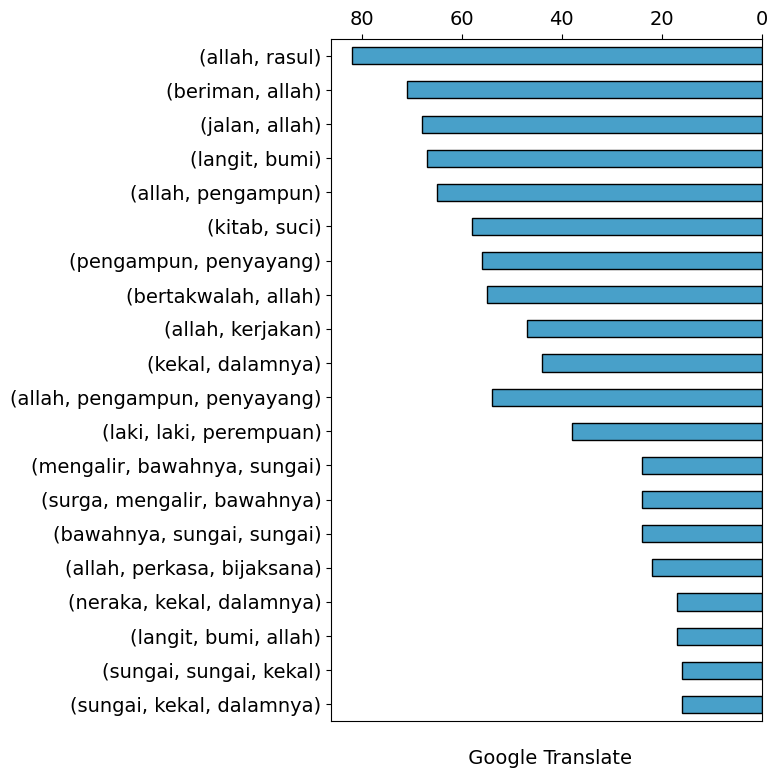

In [ ]:
bigram1 = ngrams_series_func(text, 2)
trigram1 = ngrams_series_func(text, 3)



ngram1 = pd.concat([bigram1, trigram1])


plt.rcParams.update({'font.size': 14})
#fig, ax=plt.subplots(1,2, figsize=(16,8), gridspec_kw = {'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})
fig, ax=plt.subplots(1,1, figsize=(8,8))

#barh_ax = ax[0]
barh_ax = ax

ngram1[::-1].plot.barh(ax=barh_ax, color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('\n Google Translate')
barh_ax.set_ylabel('',fontsize=50)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/Bigrams-Trigrams/ngram_google.png", dpi=300, bbox_inches='tight')


In [ ]:
topic_df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_2.csv')


for chapter in madaniyah_chapters:
  df = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_' + str(chapter) + '.csv')
  topic_df = pd.concat([topic_df, df], axis=0)


In [ ]:
from nltk.corpus import stopwords

# Gunakan stopwords Bahasa Indonesia
stop_words = stopwords.words('indonesian')
custom_stopwords = ['orang', 'maha']
stop_words.extend(custom_stopwords)

def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(text)) if word not in stop_words] for text in texts]

def tokenize(texts):
    for text in texts:
        yield gensim.utils.simple_preprocess(str(text), deacc=True)

def preprocessing(df):
    df['teks'] = df['teks'].str.lower()
    df['teks'] = df['teks'].str.replace("[^a-zA-Z#]", " ", regex=True)
    df['teks'] = df['teks'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
    df['tokens'] = list(tokenize(df['teks']))
    df['tokens_no_stop'] = remove_stopwords(df['teks'])
    df['tokens_joined'] = df['teks'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))
    df['tokens_no_stop_joined'] = df['teks'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in stop_words]))
    return df

def retrieve_text(df):
    return '. '.join(df['tokens_joined'])

def ngrams_series_func(text, n):
    words = re.sub("[^\w]", " ", text).split()
    return pd.Series(nltk.ngrams(words, n)).value_counts().head(10)



In [ ]:
topic_df = preprocessing(topic_df)
topic_df

,teks,amarah,antisipasi,menjijikkan,takut,sukacita,Cinta,optimisme,pesimisme,kesedihan,kejutan,memercayai,tokens,tokens_no_stop,tokens_joined,tokens_no_stop_joined
0,kitab tidak keraguan padanya petunjuk bagi mereka yang bertakwa,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[kitab, tidak, keraguan, padanya, petunjuk, bagi, mereka, yang, bertakwa]","[kitab, keraguan, petunjuk, bertakwa]",kitab keraguan petunjuk bertakwa,kitab keraguan petunjuk bertakwa
1,orang orang yang beriman kepada yang gaib mendirikan shalat menafkahkan sebagian rezeki yang kami berikan kepada mereka,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[orang, orang, yang, beriman, kepada, yang, gaib, mendirikan, shalat, menafkahkan, sebagian, rezeki, yang, kami, berikan, kepada, mereka]","[beriman, gaib, mendirikan, shalat, menafkahkan, rezeki]",beriman gaib mendirikan shalat menafkahkan rezeki,beriman gaib mendirikan shalat menafkahkan rezeki
2,orang orang yang beriman kepada kitab yang diturunkan kepadamu kitab yang diturunkan sebelum kamu kepada kehidupan akhirat mereka adalah yakin,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,"[orang, orang, yang, beriman, kepada, kitab, yang, diturunkan, kepadamu, kitab, yang, diturunkan, sebelum, kamu, kepada, kehidupan, akhirat, mereka, adalah, yakin]","[beriman, kitab, diturunkan, kepadamu, kitab, diturunkan, kehidupan, akhirat]",beriman kitab diturunkan kepadamu kitab diturunkan kehidupan akhirat,beriman kitab diturunkan kepadamu kitab diturunkan kehidupan akhirat
3,mereka itulah yang mendapat petunjuk dari tuhannya mereka itulah orang orang yang beruntung,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[mereka, itulah, yang, mendapat, petunjuk, dari, tuhannya, mereka, itulah, orang, orang, yang, beruntung]","[petunjuk, tuhannya, beruntung]",petunjuk tuhannya beruntung,petunjuk tuhannya beruntung
4,sesungguhnya orang orang kafir sama saja bagi mereka kamu beri peringatan atau tidak kamu beri peringatan mereka tidak akan beriman,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,"[sesungguhnya, orang, orang, kafir, sama, saja, bagi, mereka, kamu, beri, peringatan, atau, tidak, kamu, beri, peringatan, mereka, tidak, akan, beriman]","[sesungguhnya, kafir, peringatan, peringatan, beriman]",sesungguhnya kafir peringatan peringatan beriman,sesungguhnya kafir peringatan peringatan beriman
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,wahai orang orang yang beriman bertobatlah kepada allah dengan taubat yang tulus mudah mudahan tuhanmu akan menghapus kesalahan kesalahanmu memasukkanmu dalam surga yang mengalir bawahnya sungai sungai pada hari ketika allah tidak akan mempermalu...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,"[wahai, orang, orang, yang, beriman, bertobatlah, kepada, allah, dengan, taubat, yang, tulus, mudah, mudahan, tuhanmu, akan, menghapus, kesalahan, kesalahanmu, memasukkanmu, dalam, surga, yang, mengalir, bawahnya, sungai, sungai, pada, hari, keti...","[beriman, bertobatlah, allah, taubat, tulus, mudah, mudahan, tuhanmu, menghapus, kesalahan, kesalahanmu, memasukkanmu, surga, mengalir, bawahnya, sungai, sungai, allah, mempermalukan, nabi, beriman, bersamanya, cahaya, bersinar, hadapan, sebelah,...",beriman bertobatlah allah taubat tulus mudah mudahan tuhanmu menghapus kesalahan kesalahanmu memasukkanmu surga mengalir bawahnya sungai sungai allah mempermalukan nabi beriman bersamanya cahaya bersinar hadapan sebelah kanan tuhan sempurnakanlah...,beriman bertobatlah allah taubat tulus mudah mudahan tuhanmu menghapus kesalahan kesalahanmu memasukkanmu surga mengalir bawahnya sungai sungai allah mempermalukan nabi beriman bersamanya cahaya bersinar hadapan sebelah kanan tuhan sempurnakanlah...
8,wahai nabi perangilah orang orang kafir munafik bersikaplah keras terhadap mereka tempat kembali mereka adalah neraka seburuk buruk tempat kembali,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[wahai, nabi, perangilah, orang, orang, kafir, munafik, bersikaplah, keras, terhadap, mereka, tempat, kembali, mereka, a

In [ ]:
df_amarah = topic_df[topic_df['amarah'] == 1]
df_antisipasi = topic_df[topic_df['antisipasi'] == 1]
df_menjijikkan = topic_df[topic_df['menjijikkan'] == 1]
df_takut = topic_df[topic_df['takut'] == 1]
df_sukacita = topic_df[topic_df['sukacita'] == 1]
df_cinta = topic_df[topic_df['Cinta'] == 1]
df_optimisme = topic_df[topic_df['optimisme'] == 1]
df_pesimisme = topic_df[topic_df['pesimisme'] == 1]
df_kesedihan = topic_df[topic_df['kesedihan'] == 1]
df_kejutan = topic_df[topic_df['kejutan'] == 1]
df_memercayai = topic_df[topic_df['memercayai'] == 1]


In [ ]:
text_amarah = '. '.join(df_amarah.tokens_no_stop_joined)
text_antisipasi = '. '.join(df_antisipasi.tokens_no_stop_joined)
text_menjijikkan = '. '.join(df_menjijikkan.tokens_no_stop_joined)
text_takut = '. '.join(df_takut.tokens_no_stop_joined)
text_sukacita = '. '.join(df_sukacita.tokens_no_stop_joined)
text_cinta = '. '.join(df_cinta.tokens_no_stop_joined)
text_optimisme = '. '.join(df_optimisme.tokens_no_stop_joined)
text_pesimisme = '. '.join(df_pesimisme.tokens_no_stop_joined)
text_kesedihan = '. '.join(df_kesedihan.tokens_no_stop_joined)
text_kejutan = '. '.join(df_kejutan.tokens_no_stop_joined)
text_memercayai = '. '.join(df_memercayai.tokens_no_stop_joined)


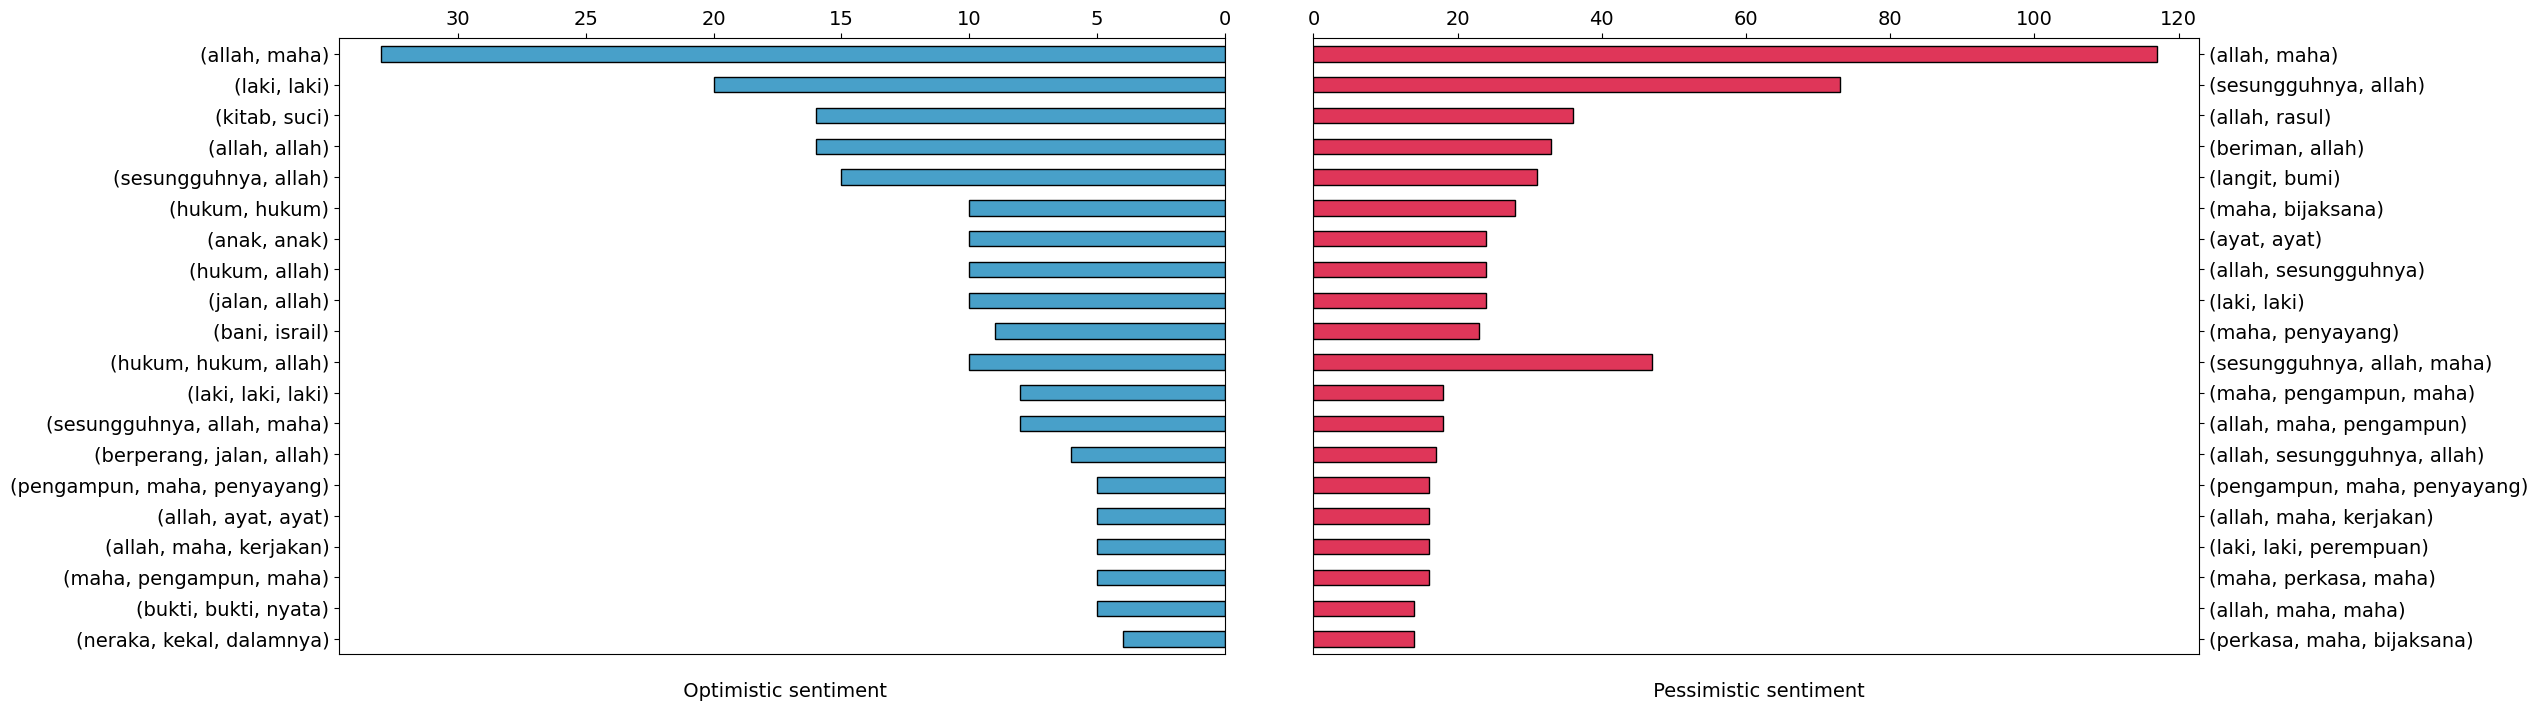

In [ ]:
bigram1 = ngrams_series_func(text_optimisme, 2)
trigram1 = ngrams_series_func(text_optimisme, 3)

# print(bigram1)

bigram2 = ngrams_series_func(text_pesimisme, 2)
trigram2 = ngrams_series_func(text_pesimisme, 3)

ngram1 = pd.concat([bigram1, trigram1])
ngram2 = pd.concat([bigram2, trigram2])

plt.rcParams.update({'font.size': 14})
fig, ax=plt.subplots(1,2, figsize=(24,8), gridspec_kw = {'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})

barh_ax = ax[0]
ngram1[::-1].plot.barh(ax=barh_ax, color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
# barh_ax.xaxis.set_major_formatter(formatterK2)
# barh_ax.set_xlim([0, 1200])
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('\n Optimistic sentiment')
barh_ax.set_ylabel('',fontsize=50)
#barh_ax.set_xticks([0,0.5,1,1.5,2.0,2.5,3], minor=False)

barh_ax = ax[1]
ngram2[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
# barh_ax.xaxis.set_major_formatter(formatterK2)
# barh_ax.set_xlim([0, 1200])
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
# barh_ax.set_xlabel('Tri N-gram Count - Trump Dataset', fontsize=13)
barh_ax.set_ylabel('', fontsize=50)
barh_ax.set_xlabel('\n Pessimistic sentiment')
plt.show()

In [ ]:
sentiments = ['amarah', 'antisipasi', 'menjijikkan', 'takut', 'sukacita', 'Cinta', 'optimisme', 'pesimisme', 'kesedihan', 'kejutan', 'memercayai']

def return_sentiments(data, row):

    text = ''

    for sentiment in sentiments:
      if data[sentiment][row] == 1:
        text+=sentiment
        text+=', '

    # print(text)
    return text

In [ ]:
sentiments = ['amarah', 'antisipasi', 'menjijikkan', 'takut', 'sukacita', 'Cinta', 'optimisme', 'pesimisme', 'kesedihan', 'kejutan', 'memercayai']

data = pd.DataFrame(columns=[
    'Chapter', 'Verse No.', 'Author', 'Verse', 'Predicted Sentiments',
    'Google vs Kemenag', 'Google vs Fahd', 'Kemenag vs Fahd'
])

# Load semantic similarity once
semantic_comparison = pd.read_csv('/content/drive/MyDrive/google-quran-translate-evaluation/Semantic Analysis Results/Cosine Similarity/cosine_similarity.csv')

for chapter in madaniyah_chapters:

    # Load sentiment predictions
    df_google = pd.read_csv(f'/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted google/chapter_{chapter}.csv')
    df_kemenag = pd.read_csv(f'/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted kemenag/chapter_{chapter}.csv')
    df_fahd = pd.read_csv(f'/content/drive/MyDrive/google-quran-translate-evaluation/Sentiment Analysis Results/predicted fahd/chapter_{chapter}.csv')

    # Jumlah ayat di chapter ini
    num_verses = df_google.shape[0]

    for i in range(num_verses):

        for author, df_source in zip(['Google Translate', 'Kemenag', 'King Fahd'], [df_google, df_kemenag, df_fahd]):

            pr_sentiments = return_sentiments(df_source, i)
            verse_text = df_source['Tweet'][i] if 'Tweet' in df_source.columns else df_source['teks'][i]

            if author == 'Google Translate':
                sim_gk = semantic_comparison.loc[i, 'Kemenag - Google']
                sim_gf = semantic_comparison.loc[i, 'Fahd - Google']
                sim_kf = ''
            elif author == 'Kemenag':
                sim_gk = ''
                sim_gf = ''
                sim_kf = semantic_comparison.loc[i, 'Fahd - Kemenag']
            else:  # King Fahd
                sim_gk = ''
                sim_gf = ''
                sim_kf = ''

            row = {
                'Chapter': chapter if author == 'Google Translate' else '',
                'Verse No.': i + 1,
                'Author': author,
                'Verse': verse_text,
                'Predicted Sentiments': pr_sentiments,
                'Google vs Kemenag': sim_gk,
                'Google vs Fahd': sim_gf,
                'Kemenag vs Fahd': sim_kf
            }

            data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)

# Tampilkan 20 baris pertama
data.head(20)


,Chapter,Verse No.,Author,Verse,Predicted Sentiments,Google vs Kemenag,Google vs Fahd,Kemenag vs Fahd
0,2,1,Google Translate,Kitab ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa.,"amarah, kejutan, memercayai,",0.923101,0.937622,
1,,1,Kemenag,"Kitab (Alquran) ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa,","pesimisme, kesedihan, kejutan,",,,0.958196
2,,1,King Fahd,"Kitab (Al-Qur`ān) ini tidak ada keraguan padanya; petunjuk bagi mereka yang bertakwa,","amarah, antisipasi, pesimisme, kejutan,",,,
3,2,2,Google Translate,"Orang-orang yang beriman kepada yang gaib, mendirikan shalat, dan menafkahkan sebagian rezeki yang Kami berikan kepada mereka.","amarah, menjijikkan, kejutan, memercayai,",0.861462,0.904171,
4,,2,Kemenag,"(Yaitu) mereka yang beriman kepada yang gaib, melaksanakan salat, dan menginfakkan sebagian rezeki yang Kami berikan kepada mereka,","amarah, menjijikkan, kejutan, memercayai,",,,0.928805
5,,2,King Fahd,"(yaitu) mereka yang beriman kepada yang gaib, yang mendirikan salat, dan menafkahkan sebagian rezeki yang Kami anugerahkan kepada mereka,","amarah, menjijikkan, sukacita, kejutan, memercayai,",,,
6,2,3,Google Translate,"Dan orang-orang yang beriman kepada kitab yang diturunkan kepadamu dan kitab yang diturunkan sebelum kamu, dan kepada kehidupan akhirat, mereka adalah yakin.","amarah, antisipasi, sukacita, pesimisme, kejutan,",0.803207,0.840195,
7,,3,Kemenag,"dan mereka beriman kepada (Alquran) yang diturunkan kepadamu (Muhammad) dan (kitab-kitab) yang telah diturunkan sebelum engkau, dan mereka yakin akan adanya akhirat.","amarah, sukacita, kejutan,",,,0.917949
8,,3,King Fahd,"dan mereka yang beriman kepada Kitab (Al-Qur`ān) yang telah diturunkan kepadamu dan kitab-kitab yang telah diturunkan sebelummu, serta mereka yakin akan adanya (kehidupan) akhirat.","amarah, kejutan, memercayai,",,,
9,2,4,Google Translate,Mereka itulah yang mendapat petunjuk dari Tuhannya dan mereka itulah orang-orang yang beruntung.,"amarah, kejutan, memercayai,",0.987814,0.880407,
